In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os

In [2]:

BATCH_SIZE = 32
# VALIDATION_SPLIT = 0.2
TEST_SPLIT = 0.1
NUM_EPOCHS = 50

# Constants
FRAME_HEIGHT = 224
FRAME_WIDTH = 224
SEQUENCE_LENGTH = 30

ARCHITECTURE = '2D_CNN_LSTM'
CNN_TYPE = 'resnet18'
# CNN_TYPE = 'mobilenet_v3'
# LSTM_HIDDEN_SIZE=512
LSTM_HIDDEN_SIZE=512
LSTM_LAYERS = 1
DROPOUT = 0.5
LEARNING_RATE = 0.001
NUM_LAYERS_TO_UNFREEZE = 1
FROZEN = True

In [6]:
import os

# root directory of uploaded dataset
# dataset_root = "/kaggle/input/updated-yoga-dataset/"
# dataset_root = "/kaggle/input/"
old_dataset_root = "/kaggle/input/yoga-dataset/"
dataset_root = old_dataset_root
# video files directory
video_dir = os.path.join(old_dataset_root, "short/short/")

# metadata directory
metadata_dir = os.path.join(dataset_root, "data/data/")

# csv file containing labels
csv_path = os.path.join(metadata_dir, "3DYoga90_corrected.csv")

# path to store additional metadata files
meta_info_path = os.path.join('/kaggle/working/', 'fold_save')  # same as metadata_dir
os.makedirs(meta_info_path, exist_ok=True)
# paths for logging valid and corrupted samples
sequence_path = os.path.join(video_dir, "downloaded_log.txt")
corrupted_path = os.path.join('/kaggle/working/', "corrupted_log.txt")

# directory to store preprocessed videos
preprocessed_dir = os.path.join(dataset_root, "RESIZED_DATA")
os.makedirs(preprocessed_dir, exist_ok=True)

FOLD_CHECKPOINT_PATH = os.path.join('/kaggle/working/', 'FOLD_CHECKPOINT')


# print paths for verification
print(f"dataset root: {dataset_root}")
print(f"video directory: {video_dir}")
print(f"metadata directory: {metadata_dir}")
print(f"csv path: {csv_path}")
print(f"metadata info path: {meta_info_path}")
print(f"valid sequences log: {sequence_path}")
# print(f"corrupted sequences log: {corrupted_log_path}")
print(f"preprocessed data directory: {preprocessed_dir}")

dataset root: /kaggle/input/yoga-dataset/
video directory: /kaggle/input/yoga-dataset/short/short/
metadata directory: /kaggle/input/yoga-dataset/data/data/
csv path: /kaggle/input/yoga-dataset/data/data/3DYoga90_corrected.csv
metadata info path: /kaggle/working/fold_save
valid sequences log: /kaggle/input/yoga-dataset/short/short/downloaded_log.txt
preprocessed data directory: /kaggle/input/yoga-dataset/RESIZED_DATA


In [7]:
!ls /kaggle/input/yoga-dataset

data  RESIZED_DATA  short


In [8]:
!ls /kaggle/input/3dyoga90/data/data/

2D_CNN_LSTM_folds.pkl	3DYoga90.csv	      criterion_fold_1.pkl  skf.pkl
2D_CNN_LSTM_skf.pkl	3DYoga90.json	      folds.pkl
3DYoga90_corrected.csv	criterion_fold_0.pkl  pose-index.csv


In [9]:
import os

# Define paths
paths_to_check = {
    "dataset root": dataset_root,
    "video directory": video_dir,
    "metadata directory": metadata_dir,
    "csv file": csv_path,
    "metadata info path": meta_info_path,
    "valid sequences log": sequence_path,
    "corrupted sequences log": corrupted_path,
    "preprocessed data directory": preprocessed_dir
}

# Check existence
for name, path in paths_to_check.items():
    if os.path.exists(path):
        if os.path.isfile(path):
            print(f"[✔] {name} exists and is a file: {path}")
        elif os.path.isdir(path):
            print(f"[✔] {name} exists and is a directory: {path}")
    else:
        print(f"[✘] {name} does NOT exist: {path}")


[✔] dataset root exists and is a directory: /kaggle/input/yoga-dataset/
[✔] video directory exists and is a directory: /kaggle/input/yoga-dataset/short/short/
[✔] metadata directory exists and is a directory: /kaggle/input/yoga-dataset/data/data/
[✔] csv file exists and is a file: /kaggle/input/yoga-dataset/data/data/3DYoga90_corrected.csv
[✔] metadata info path exists and is a directory: /kaggle/working/fold_save
[✔] valid sequences log exists and is a file: /kaggle/input/yoga-dataset/short/short/downloaded_log.txt
[✘] corrupted sequences log does NOT exist: /kaggle/working/corrupted_log.txt
[✔] preprocessed data directory exists and is a directory: /kaggle/input/yoga-dataset/RESIZED_DATA


In [10]:
file_path = os.path.join(video_dir, "missing_videos_log.txt")

# Count lines in the file
with open(file_path, "r", encoding="utf-8") as f:
    line_count = sum(1 for _ in f)

print(f"Number of lines in missing_videos.txt: {line_count}")

Number of lines in missing_videos.txt: 303


In [11]:
file_path = os.path.join(video_dir, "downloaded_log.txt")

# Count lines in the file
with open(file_path, "r", encoding="utf-8") as f:
    line_count = sum(1 for _ in f)

print(f"Number of lines in missing_videos.txt: {line_count}")

Number of lines in missing_videos.txt: 1944


In [12]:
!ls /kaggle/working

BS32_KAGGLE_CROSS_FOLD_2D_CNN_LSTM_2025-02-23_LR0.001_LHS512_LL1_CTresnet18
FOLD_CHECKPOINT
fold_save
state.db


In [13]:
import os
from datetime import datetime

today = datetime.today().strftime('%Y-%m-%d')
SAVE_PATH = os.path.join(
    '/kaggle/working/',
    f'BS{BATCH_SIZE}_KAGGLE_CROSS_FOLD_{ARCHITECTURE}_{today}_LR{LEARNING_RATE}_LHS{LSTM_HIDDEN_SIZE}_LL{LSTM_LAYERS}_CT{CNN_TYPE}_FROZEN_{FROZEN}_NLUF_{NUM_LAYERS_TO_UNFREEZE}'
)
os.makedirs(SAVE_PATH, exist_ok=True)
print(SAVE_PATH)

pose_list = ['downward-dog','standing-forward-bend','half-way-lift',
             'mountain','chair','cobra','cockerel','extended-triangle',
             'extended-side-angle','corpse','staff','wind-relieving','fish'
            ]

subset_of_poses = pose_list
NUM_CLASSES = len(pose_list)

In [14]:
# SAVE_PATH = '/kaggle/working/BS32_KAGGLE_CROSS_FOLD_2D_CNN_LSTM_2025-02-23_LR0.001_LHS512_LL1_CTresnet18'

In [15]:
print(torch.__version__)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

2.5.1+cu121


In [16]:
# meta_info_path = os.path.join(base_path, 'data')
# pose_index = pd.read_csv(f'{meta_info_path}/pose-index.csv')
# sequence_index = pd.read_csv(f'{meta_info_path}/3DYoga90_corrected.csv')

What does each file tell?

1.) pose-index.csv -> Shows Heirarchical organization (THEN NOTHING MORE)

2.) 3DYoga90.csv -> Total Main Info(i.e. along with RGB stream){
    SequneceID: Parquet_FILE_NAME,
    URL,
    Frame Start and Frame Stop,
    Pose Name, Training Test Split
} `Difference between train and test? where to get the validation set from? How to do data augmentation?

3.) Parquet Files -> {
    Frame Number {
        33 Landmarks
    },
    row-id: FrameNumber-TYPE-Landmark_index,
    Coordinates: {x, y, z}
}

`PLEASE NOTE: The landmark coordinates are all normalized`

# Getting the data ready

In [17]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.transforms.v2 as T
import random

class VideoAugmentationPipeline:
    """Video augmentation pipeline using batch transforms from torchvision.transforms.v2"""
    def __init__(self, spatial_aug_config=None, temporal_aug_config=None):
        # Default config with all augmentations enabled
        default_spatial_config = {
            'random_resized_crop': {'enabled': False, 'scale': (0.9, 1.0)},
            'random_horizontal_flip': {'enabled': True, 'p': 0.5},
            'color_jitter': {'enabled': True, 'brightness': 0.1, 'contrast': 0.1, 'saturation': 0.1, 'p': 0.5},
            'gaussian_blur': {'enabled': True, 'p': 0.5},
            'random_rotation': {'enabled': True, 'degrees': (-5, 5),'p':0.5},
        }

        default_temporal_config = {
            'temporal_crop': {'enabled': True, 'crop_size': 0.9},
            'temporal_mask': {'enabled': True, 'n_masks': 1, 'mask_size': 0.1},
        }

        # Update default config with user-provided config
        self.spatial_aug_config = self._update_config(default_spatial_config, spatial_aug_config)
        self.temporal_aug_config = self._update_config(default_temporal_config, temporal_aug_config)

        # Build transforms that can handle batch inputs
        self.spatial_transforms = self._build_spatial_transforms()

    def _update_config(self, default_config, user_config):
        """Update default config with user config, disabling augmentations not in user config"""
        if user_config is None:
            return default_config

        updated_config = default_config.copy()
        for aug_name in updated_config:
            if aug_name in user_config:
                # # Update probability if provided
                # if isinstance(user_config[aug_name], dict):
                #     updated_config[aug_name].update(user_config[aug_name])
                # else:
                    updated_config[aug_name]['p'] = user_config[aug_name]
            else:
                # Disable augmentation if not in user config
                updated_config[aug_name]['enabled'] = False
        return updated_config

    def _build_spatial_transforms(self):
        """Build composition of spatial transforms that support batch processing"""
        transform_list = []

        if self.spatial_aug_config['random_resized_crop']['enabled']:
            transform_list.append(
                T.RandomResizedCrop(
                    size=(224, 224),
                    scale=self.spatial_aug_config['random_resized_crop']['scale'],
                    antialias=True
                )
            )

        if self.spatial_aug_config['random_horizontal_flip']['enabled']:
            transform_list.append(
                T.RandomHorizontalFlip(p=self.spatial_aug_config['random_horizontal_flip']['p'])
            )

        if self.spatial_aug_config['color_jitter']['enabled']:
            transform_list.append(
                T.ColorJitter(
                    brightness=self.spatial_aug_config['color_jitter']['brightness'],
                    contrast=self.spatial_aug_config['color_jitter']['contrast'],
                    saturation=self.spatial_aug_config['color_jitter']['saturation']
                )
            )

        if self.spatial_aug_config['gaussian_blur']['enabled']:
            transform_list.append(
                T.GaussianBlur(
                    kernel_size=(5, 5),
                    sigma=(0.1, 1.0)
                )
            )

        if self.spatial_aug_config['random_rotation']['enabled']:
            if random.random() < self.spatial_aug_config['random_rotation']['p']:
                transform_list.append(
                    T.RandomRotation(
                        degrees=self.spatial_aug_config['random_rotation']['degrees'],
                        interpolation=T.InterpolationMode.BILINEAR
                    )
                )

        return T.Compose(transform_list)

    def apply_temporal_augmentation(self, video_tensor):
        """Apply temporal augmentations to video tensor"""
        if not any(cfg['enabled'] for cfg in self.temporal_aug_config.values()):
            return video_tensor

        T, C, H, W = video_tensor.shape

        # Temporal crop
        if self.temporal_aug_config['temporal_crop']['enabled']:
            crop_size = int(T * self.temporal_aug_config['temporal_crop']['crop_size'])
            start_idx = random.randint(0, T - crop_size)
            video_tensor = video_tensor[start_idx:start_idx + crop_size]

        # Temporal masking
        if self.temporal_aug_config['temporal_mask']['enabled']:
            T = len(video_tensor)
            mask_size = int(T * self.temporal_aug_config['temporal_mask']['mask_size'])
            for _ in range(self.temporal_aug_config['temporal_mask']['n_masks']):
                if random.random() < 0.5:
                    start_idx = random.randint(0, T - mask_size)
                    video_tensor[start_idx:start_idx + mask_size] = 0

        return video_tensor

    def __call__(self, video_tensor):
        """Apply transforms to entire video tensor at once"""
        # Input shape: [T, C, H, W]
        # Reshape to [T, C, H, W] -> [1, T, C, H, W] for batch processing
        video_tensor = video_tensor.unsqueeze(0)

        # Apply spatial transforms to entire video tensor at once
        # transforms.v2 will maintain temporal consistency automatically
        video_tensor = self.spatial_transforms(video_tensor)

        # Remove batch dimension
        video_tensor = video_tensor.squeeze(0)

        # Apply temporal augmentations
        # video_tensor = self.apply_temporal_augmentation(video_tensor)

        return video_tensor

In [18]:
import os
import torch
import pandas as pd
import numpy as np
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import imageio
import random

class YogaVideoDataset(Dataset):
    def __init__(self, csv_path, sequence_path, pose_list, video_dir, preprocessed_dir,
                 spatial_aug_config=None, temporal_aug_config=None, use_augmentation=True, aug_ratio = 0.5):
        with open(sequence_path) as f:
            sequence_list = f.read().splitlines()
            sequence_list = [int(x) for x in sequence_list]

        self.df = pd.read_csv(csv_path)
        self.df = self.df[self.df['sequence_id'].isin(sequence_list)]
        self.df = self.df[self.df['l3_pose'].isin(pose_list)]

        self.pose_to_label = {pose: idx for idx, pose in enumerate(pose_list)}
        self.length_of_dataset = len(self.df)
        self.idx_to_label = {}

        self.video_dir = video_dir
        self.preprocessed_dir = preprocessed_dir
        os.makedirs(self.preprocessed_dir, exist_ok=True)

        # Initialize augmentation pipeline
        self.augmentation_pipeline = VideoAugmentationPipeline(
            spatial_aug_config=spatial_aug_config,
            temporal_aug_config=temporal_aug_config
        )

        self.cache = dict()
        self.augmentation_ratio = aug_ratio
        self.use_augmentation = use_augmentation

        self.transforms = transforms.Compose([
            transforms.Resize((FRAME_HEIGHT, FRAME_WIDTH)),
            transforms.ToTensor(),
            # transforms.Normalize(mean=[0.485, 0.456, 0.406],
            #                      std=[0.229, 0.224, 0.225])
        ])
        self.normalization = transforms.Compose([
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
    def __len__(self):
        return self.length_of_dataset

    def __getitem__(self, i):
        sequence_id = self.df.iloc[i]['sequence_id']
        pose = self.df.iloc[i]['l3_pose']
        label = self.pose_to_label[pose]
        self.idx_to_label[i] = sequence_id
        # Load preprocessed frames
        if sequence_id in self.cache:
            frames = self.cache[sequence_id]
        else:
            file_path = os.path.join(self.preprocessed_dir, f"{sequence_id}.pt")
            if not os.path.exists(file_path):
                video_path = os.path.join(self.video_dir, f"{sequence_id}.mp4")
                frames = self._get_frames(video_path)
                torch.save(frames, file_path)
            else:
                frames = torch.load(file_path, weights_only=True)
            # self.cache[sequence_id] = frames

        # Choose whether to use augmented or original data
        use_augmented_data = self.use_augmentation and self.augmentation_ratio < random.random()
        if use_augmented_data:
            frames = self.augmentation_pipeline(frames)

        frames = self.normalization(frames)
        return frames, label

    def _get_frames(self, video_path, sequence_length=SEQUENCE_LENGTH, corrupted_log_path = corrupted_path):
        reader = imageio.get_reader(video_path, 'ffmpeg')
        fps = imageio.get_reader(video_path, 'ffmpeg').get_meta_data()['fps'] // 1
        total_frames = reader.count_frames()



        # Calculate frame indices to sample
        indices = np.linspace(0, total_frames - 1, num=sequence_length, dtype=int)
        t_indices =[]
        frames = []
        for i, frame in enumerate(reader):
            if i in indices:
                frame = Image.fromarray(frame)
                frame = self.transforms(frame)
                frames.append(frame)
                t_indices.append(i)
                # print('Frame number', i % fps, 'Frame', i)

        reader.close()

        # If extracted frames do not match sequence_length, log to corrupted_log_path
        if len(frames) != sequence_length:
            with open(corrupted_log_path, "a") as f:
                f.write(f"Corrupted video: {video_path}\n")
                f.write(f"Expected {sequence_length} frames, got {len(frames)}\n")
                f.write(f"Selected frame indices: {t_indices}\n\n")
            print(f"Processing video: {video_path}")
            print(f"Total frames: {total_frames}")
            print(f"Total frames: {t_indices}")
            print(f"Final frame count: {len(frames)}")


        # Ensure frames tensor has correct shape
        if frames:
            frames = torch.stack(frames)
        else:
            frames = torch.empty(0)  # Return an empty tensor if no frames are found

        return frames

In [1]:

import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn_utils
import math

class AttentionLayer(nn.Module):
    """Basic attention mechanism for sequence processing"""
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.W = nn.Linear(input_size, hidden_size)
        self.V = nn.Linear(hidden_size, 1)
        
        # Initialize attention weights
        nn.init.xavier_uniform_(self.W.weight)
        nn.init.xavier_uniform_(self.V.weight)
        nn.init.zeros_(self.W.bias)
        nn.init.zeros_(self.V.bias)

    def forward(self, lstm_output, mask=None):
        att_scores = self.V(torch.tanh(self.W(lstm_output))).squeeze(-1)

        if mask is not None:
            att_scores = att_scores.masked_fill(mask == 0, -1e9)

        att_weights = F.softmax(att_scores, dim=1)
        context = (lstm_output * att_weights.unsqueeze(-1)).sum(1)
        return context, att_weights

class CNNLSTM(nn.Module):
    """Modular video action classifier with various configuration options"""
    def __init__(self, num_classes,
                 lstm_hidden_size=512,
                 lstm_layers=1,
                 dropout=0.5,
                 freeze_cnn=True,
                 use_attention=False,
                 cnn_model='resnet18'):

        super().__init__()
        self.use_attention = use_attention
        self.cnn_model = cnn_model

        # CNN Feature Extractor
        self.cnn, self.cnn_feature_size = self._build_cnn(cnn_model)
        self._set_cnn_freeze(freeze_cnn)

        # Adjust LSTM input size based on CNN feature size
        lstm_input_size = self.cnn_feature_size

        # Sequence Processing
        self.lstm = nn.LSTM(
            input_size=lstm_input_size,
            hidden_size=lstm_hidden_size,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=dropout if lstm_layers > 1 else 0
        )
        
        # Initialize LSTM weights properly
        self._init_lstm_weights()

        # Attention Mechanism
        if self.use_attention:
            self.attention = AttentionLayer(
                input_size=lstm_hidden_size,
                hidden_size=lstm_hidden_size
            )

        # Simplified Classification Head
        self.classifier = self._build_classifier(
            lstm_hidden_size,
            num_classes,
            dropout
        )

        # Initialize classifier weights
        self._initialize_weights()

    def _build_cnn(self, model_name):
        """Initialize CNN feature extractor with proper feature sizes"""
        if model_name == 'resnet18':
            cnn = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
            return nn.Sequential(*list(cnn.children())[:-2]), 512  # Remove avgpool and fc
        elif model_name == 'mobilenet_v3':
            cnn = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.DEFAULT)
            # Remove classifier and avgpool layers
            return nn.Sequential(*list(cnn.children())[:-2]), 576  # Feature size for mobilenet_v3_small
        else:
            raise ValueError(f"Unsupported CNN model: {model_name}")

    def _build_classifier(self, input_size, num_classes, dropout):
        """Build a minimal classification head with a single layer"""
        return nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(input_size, num_classes)
        )
    def _init_lstm_weights(self):
        """Initialize LSTM weights using orthogonal initialization"""
        for name, param in self.lstm.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)
    def _initialize_weights(self):
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)  # Replace Kaiming with Xavier
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    def _set_cnn_freeze(self, freeze):
        """Freeze/unfreeze CNN parameters"""
        for param in self.cnn.parameters():
            param.requires_grad = not freeze

    def forward(self, x, lengths):
        # Process frames through CNN
        batch_size, seq_len = x.size(0), x.size(1)
        x = x.view(batch_size*seq_len, *x.size()[2:])
        x = self.cnn(x)
        
        # Use same adaptive pooling for both models for consistency
        x = F.adaptive_avg_pool2d(x, (1, 1))
            
        # Reshape for sequence processing
        x = x.view(batch_size, seq_len, -1)

        # Process sequence through LSTM
        packed_x = rnn_utils.pack_padded_sequence(
            x, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        packed_out, _ = self.lstm(packed_x)
        lstm_out, _ = rnn_utils.pad_packed_sequence(packed_out, batch_first=True)

        # Get final representation
        if self.use_attention:
            mask = self._create_attention_mask(lstm_out.size(1), lengths)
            context, _ = self.attention(lstm_out, mask)
        else:
            # Get last valid time step output
            indices = torch.clamp(lengths - 1, min=0)  # Prevent negative indices
            context = lstm_out[torch.arange(batch_size), indices, :]

        return self.classifier(context)

    def _create_attention_mask(self, max_len, lengths):
        """Create attention mask from sequence lengths"""
        device = lengths.device
        return torch.arange(max_len, device=device).expand(len(lengths), max_len) < lengths.unsqueeze(1)

    def unfreeze_cnn_layers(self, num_layers=3, start_from_end=True):
        """Gradually unfreeze CNN layers for fine-tuning"""
        # Get all CNN layers, not just conv layers
        all_cnn_layers = []
        for name, module in self.cnn.named_modules():
            if isinstance(module, (nn.Conv2d, nn.BatchNorm2d)):
                all_cnn_layers.append(module)
        
        # Sort conv layers first then BN layers
        conv_layers = [l for l in all_cnn_layers if isinstance(l, nn.Conv2d)]
        bn_layers = [l for l in all_cnn_layers if isinstance(l, nn.BatchNorm2d)]
        
        # Decide which layers to unfreeze
        if start_from_end:
            layers_to_unfreeze = conv_layers[-num_layers:]
            # Also unfreeze corresponding BN layers
            bn_to_unfreeze = bn_layers[-num_layers:]
        else:
            layers_to_unfreeze = conv_layers[:num_layers]
            bn_to_unfreeze = bn_layers[:num_layers]
        
        # Unfreeze selected layers
        for layer in layers_to_unfreeze + bn_to_unfreeze:
            for param in layer.parameters():
                param.requires_grad = True

    def count_parameters(self):
        """Count trainable parameters"""
        total_params = 0
        for name, parameter in self.named_parameters():
            if parameter.requires_grad:
                params = parameter.numel()
                print(f"{name}: {params}")
                total_params += params
        print(f"Total Trainable Params: {total_params}")

In [18]:
# Create model instance
model = CNNLSTM(
    num_classes=13,
    lstm_hidden_size=512,
    cnn_model='resnet18',
)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Create dummy input
batch_size = 4
seq_length = 10
channels = 3
height = 224
width = 224

# Create random input tensor and labels
x = torch.randn(batch_size, seq_length, channels, height, width).to(device)
lengths = torch.full((batch_size,), seq_length, dtype=torch.long).to(device)
labels = torch.randint(0, 13, (batch_size,)).to(device)  # Generate labels between 0 and 12 (13 classes)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Forward pass
outputs = model(x, lengths)
loss = criterion(outputs, labels)

print(f"Input shape: {x.shape}")
print(f"Output shape: {outputs.shape}")
print(f"Loss value: {loss.item():.4f}")


Input shape: torch.Size([4, 10, 3, 224, 224])
Output shape: torch.Size([4, 13])
Loss value: 2.6559


In [20]:
import os
import torch
def save_checkpoint(model, optimizer, epoch, history, save_path = SAVE_PATH, best_path=None):
    if best_path is not None:
        # chk_path = os.path.join(save_path, f'best_model.pth')
        chk_path = best_path
        print(f"Saving checkpoint to {chk_path}")
    else:
        chk_path = os.path.join(save_path, f'checkpath_model.pth')
        print(f"Saving checkpoint to {chk_path}")

    # Combine model, optimizer, and history into one dictionary
    checkpoint = {
        'epoch': epoch + 1,  # Save the next epoch number for resuming
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'history': history  # Save history along with the model and optimizer
    }

    # Save everything in a single file using torch.save
    torch.save(checkpoint, chk_path)
    print(f"Checkpoint saved at epoch {epoch + 1}")

In [21]:
def load_checkpoint(model, optimizer, checkpoint_path):
    """
    Load model and training state from a checkpoint
    """
    print(f"Loading checkpoint from {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, weights_only = False)

    # Load model and optimizer states
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # Get the epoch number to resume from
    start_epoch = checkpoint['epoch']

    # Load training history with new metrics
    history = checkpoint.get('history', {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'train_precision': [], 'train_recall': [], 'train_f1': [],
        'val_precision': [], 'val_recall': [], 'val_f1': [],
        'learning_rates': []
    })

    return model, optimizer, start_epoch, history


In [22]:
class EarlyStopping:
    """Early stopping to prevent overfitting"""
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        # on default = 7 successive val_loss increase stop
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score
import os
import matplotlib.pyplot as plt

def plot_per_class_metric(precision, recall, f1, epoch=0, pose_list=None, master_save_path=SAVE_PATH, fold= None):
    """
    Plots and saves per-class metrics (Precision, Recall, F1-score) for the given epoch.

    Args:
        precision (list): Per-class precision values.
        recall (list): Per-class recall values.
        f1 (list): Per-class F1-score values.
        epoch (int): Current epoch number.
        pose_list (list): List of class names (strings) corresponding to class indices.
        master_save_path (str): Directory to save the plot.
    """
    if pose_list is None:
        pose_list = [str(i) for i in range(len(precision))]  # Default to numeric labels

    save_dir = os.path.join(master_save_path, f'per_class_metric_{fold}')
    os.makedirs(save_dir, exist_ok=True)

    save_file_path = os.path.join(save_dir, f'per_class_metric_epoch_{epoch}.png')

    # Adjust x-axis positions for grouped bars
    x = range(len(pose_list))

    plt.bar([i - 0.2 for i in x], precision, width=0.2, label='Precision', align='center')
    plt.bar(x, recall, width=0.2, label='Recall', align='center')
    plt.bar([i + 0.2 for i in x], f1, width=0.2, label='F1-Score', align='center')

    plt.xlabel('Class')
    plt.ylabel('Score')
    plt.title(f'Per-Class Metrics - Epoch {epoch}')
    plt.xticks(x, pose_list, rotation=45, ha='right')  # Use pose_list for x-axis labels
    plt.legend()
    plt.tight_layout()  # Adjust layout to fit rotated labels
    plt.savefig(save_file_path)
    plt.show()

def per_class_metric(true, pred, epoch, pose_list=pose_list, average=None, fold=None):
    """
    Computes and logs per-class metrics (Precision, Recall, F1-score).

    Args:
        true (list): Ground-truth labels.
        pred (list): Predicted labels.
        epoch (int): Current epoch number.
        pose_list (list): List of class names (strings) corresponding to class indices.
        average (str or None): Averaging method for sklearn metrics (None for per-class).
    """
    per_class_precision = precision_score(true, pred, average=average, zero_division=0)
    per_class_recall = recall_score(true, pred, average=average, zero_division=0)
    per_class_f1 = f1_score(true, pred, average=average, zero_division=0)

    print(f"Per-Class Metrics for Epoch {epoch}:")
    for i, (prec, rec, f1) in enumerate(zip(per_class_precision, per_class_recall, per_class_f1)):
        class_name = pose_list[i] if pose_list else f"Class {i}"
        print(f"{class_name}: Precision={prec:.2f}, Recall={rec:.2f}, F1-Score={f1:.2f}")

    plot_per_class_metric(per_class_precision, per_class_recall, per_class_f1, epoch, pose_list, fold=fold)


In [24]:
import os
import torch
from torch.optim import lr_scheduler
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, dataset,fold, num_epochs=50, patience=18, log_interval=10, checkpoint_path=None, unfreeze_epoch=5, num_layers_unfreeze=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    print("Using device:", device)

    # Initialize scheduler
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=patience, min_delta=1e-4)

    start_epoch = 0
    best_val_loss = float('inf')

    # Initialize history for loss, accuracy, precision, recall, and F1
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'train_precision': [], 'train_recall': [], 'train_f1': [],
        'val_precision': [], 'val_recall': [], 'val_f1': [],
        'learning_rates': []
    }

    # Check for checkpoint and load if available
    if checkpoint_path and os.path.exists(checkpoint_path):
        model, optimizer, start_epoch, history = load_checkpoint(model, optimizer, checkpoint_path)
        print(f"Resuming training from epoch {start_epoch}")
        torch.cuda.empty_cache()

    for epoch in range(start_epoch, num_epochs):
        if epoch == 14 and not FROZEN:
            print("UNFREEZING CNN LAYERS:", NUM_LAYERS_TO_UNFREEZE)
            model.unfreeze_cnn_layers(num_layers=NUM_LAYERS_TO_UNFREEZE)
        dataset.use_augmentation = True #############
        print(f'\nEpoch {epoch + 1}/{num_epochs}')

        current_lr = optimizer.param_groups[0]['lr']
        history['learning_rates'].append(current_lr)
        print(f"Current Learning Rate: {current_lr}")

        # Training phase
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        train_true, train_pred = [], []

        train_loader_tqdm = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training")
        for batch_idx, (inputs, labels, lengths) in train_loader_tqdm:
            inputs, labels, lengths = inputs.to(device), labels.to(device), lengths.to(device)
            optimizer.zero_grad()
            outputs = model(inputs, lengths)
            loss = criterion(outputs, labels)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)
            if inputs.size(0) != BATCH_SIZE:
                print("INPUT_SIZE:", inputs.size(0))
            # Collect true and predicted labels for precision/recall
            train_true.extend(labels.cpu().numpy())
            train_pred.extend(predicted.cpu().numpy())

            # Log batch-level updates
            if batch_idx % log_interval == 0:
                train_loader_tqdm.set_postfix({
                    'loss': train_loss / (BATCH_SIZE * (batch_idx + 1)),
                    'accuracy': 100.0 * train_correct / train_total
                })

        # Calculate training metrics
        train_loss /= len(train_loader.dataset)
        print("TRAIN LOADER LENGTH:", len(train_loader.dataset))
        print("TRAIN TOTAL:", train_total)
        train_acc = 100.0 * train_correct / train_total
        train_precision = precision_score(train_true, train_pred, average='macro')
        train_recall = recall_score(train_true, train_pred, average='macro')
        train_f1 = f1_score(train_true, train_pred, average='macro')

        per_class_metric(train_true, train_pred, epoch, fold=fold)

        dataset.use_augmentation = False
        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        val_true, val_pred = [], []

        val_loader_tqdm = tqdm(enumerate(val_loader), total=len(val_loader), desc="Validation")
        with torch.no_grad():
            for batch_idx, (inputs, labels, lengths) in val_loader_tqdm:
                inputs, labels, lengths = inputs.to(device), labels.to(device), lengths.to(device)
                outputs = model(inputs, lengths)  # Pass sequence lengths to model forward function
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

                # Collect true and predicted labels for precision/recall
                val_true.extend(labels.cpu().numpy())
                val_pred.extend(predicted.cpu().numpy())

                # Log batch-level updates for validation
                if batch_idx % log_interval == 0:
                    val_loader_tqdm.set_postfix({
                        'loss': val_loss / (BATCH_SIZE * (batch_idx + 1)),
                        'accuracy': 100.0 * val_correct / val_total
                    })

        # Calculate validation metrics
        val_loss /= len(val_loader.dataset)
        val_acc = 100.0 * val_correct / val_total
        val_precision = precision_score(val_true, val_pred, average='macro')
        val_recall = recall_score(val_true, val_pred, average='macro')
        val_f1 = f1_score(val_true, val_pred, average='macro')
        # Per-class metrics for validation
        per_class_metric(val_true, val_pred, epoch, fold=fold)
        # Update history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_precision'].append(train_precision)
        history['train_recall'].append(train_recall)
        history['train_f1'].append(train_f1)
        history['val_precision'].append(val_precision)
        history['val_recall'].append(val_recall)
        history['val_f1'].append(val_f1)

        # Print metrics at the end of the epoch
        print(f'\nEpoch {epoch + 1}/{num_epochs} Summary:')
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Train Precision: {train_precision:.2f} | Train Recall: {train_recall:.2f} | Train F1: {train_f1:.2f}')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | Val Precision: {val_precision:.2f} | Val Recall: {val_recall:.2f} | Val F1: {val_f1:.2f}')

        # Save the best model checkpoint
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_path = os.path.join(SAVE_PATH, f'best_model_fold_{fold}.pth')
            if best_model_path is not None:
                print(best_model_path)
            save_checkpoint(model, optimizer, epoch, history, SAVE_PATH, best_model_path)
            print(f"New best model saved! Validation Loss: {best_val_loss:.4f}")

        # Adjust learning rate based on validation loss
        scheduler.step(val_loss)

        # Check for early stopping
        # early_stopping(val_loss)
        # if early_stopping.early_stop:
        #     print("Early stopping triggered")
        #     break

    return model, history

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import torch
import numpy as np
import os
from tqdm import tqdm

def evaluate_model(model, test_loader, criterion, class_names, spath=SAVE_PATH, fsave='confusion_matrix_accuracy.png', fold = None):
    """
    Evaluate model on test set

    Args:
        model: PyTorch model
        test_loader: DataLoader for test data
        criterion: Loss function
        class_names: List of class names
        spath: Directory to save the plot
        fsave: Filename for confusion matrix plot

    Returns:
        test_loss: Average test loss
        accuracy: Test accuracy
        precision: Macro precision score
        recall: Macro recall score
        f1: Macro F1 score
    """
    ffsave = f'fold_{fold}_{fsave}'
    csave = os.path.join(spath, ffsave)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    test_loss = 0.0
    test_correct = 0
    test_total = 0
    all_predictions = []
    all_labels = []

    test_loader_tqdm = tqdm(test_loader, desc="Testing")

    with torch.no_grad():
        for inputs, labels, lengths in test_loader_tqdm:
            inputs = inputs.to(device)
            labels = labels.to(device)
            lengths = lengths.to(device)
            outputs = model(inputs, lengths)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss = test_loss / len(test_loader.dataset)
    accuracy = 100 * test_correct / test_total

    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    
    plt.figure(figsize=(12, 10))  # Increased figure size
    plt.subplot(111, position=[0.1, 0.2, 0.8, 0.7])  # Adjust main plot position to leave room for text
    cm = confusion_matrix(all_labels, all_predictions)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # Prepare metrics text
    metrics_text = (f'Test Loss: {test_loss:.4f}\n'
                    f'Test Accuracy: {accuracy:.2f}%\n'
                    f'Precision (Weighted): {precision:.4f}\n'
                    f'Recall (Weighted): {recall:.4f}\n'
                    f'F1 Score (Weighted): {f1:.4f}')
    
    # Add metrics text to the figure
    plt.gcf().text(0, 0.01, metrics_text, fontsize=12, ha='left', va='bottom')
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)  # Leave space at bottom for metrics
    plt.savefig(csave, bbox_inches='tight')
    plt.show()
    plt.close()
    
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {accuracy:.2f}%')
    print(f'Precision (Weighted): {precision:.4f}')
    print(f'Recall (Weighted): {recall:.4f}')
    print(f'F1 Score (Weighted): {f1:.4f}')
    
    # Store metrics in a dictionary
    metrics = {
        'loss': test_loss,       # Test loss value
        'accuracy': accuracy,    # Test accuracy percentage
        'precision': precision,  # Weighted precision
        'recall': recall,        # Weighted recall
        'f1': f1                 # Weighted F1 score
    }
    
    return metrics


    # Calculate metrics with macro averaging
    # precision = precision_score(all_labels, all_predictions, average='macro')
    # recall = recall_score(all_labels, all_predictions, average='macro')
    # f1 = f1_score(all_labels, all_predictions, average='macro')
    
    # plt.figure(figsize=(12, 10))  # Increased figure size
    # plt.subplot(111, position=[0.1, 0.2, 0.8, 0.7])  # Adjust main plot position to leave room for text
    # cm = confusion_matrix(all_labels, all_predictions)

    # # plt.figure(figsize=(10, 8))
    # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
    #             xticklabels=class_names, yticklabels=class_names)
    # plt.title('Confusion Matrix')
    # plt.xlabel('Predicted')
    # plt.ylabel('True')

    # # Prepare metrics text
    # metrics_text = (f'Test Loss: {test_loss:.4f}\n'
    #                 f'Test Accuracy: {accuracy:.2f}%\n'
    #                 f'Precision (Macro): {precision:.4f}\n'
    #                 f'Recall (Macro): {recall:.4f}\n'
    #                 f'F1 Score (Macro): {f1:.4f}')

    # # Add metrics text to the figure
    # plt.gcf().text(0, 0.01, metrics_text, fontsize=12, ha='left', va='bottom')

    # plt.tight_layout()
    # plt.subplots_adjust(bottom=0.2)  # Leave space at bottom for metrics
    # # Save with tight layout to include all elements
    # plt.savefig(csave, bbox_inches='tight')
    # plt.show()
    # plt.close()

    # print(f'Test Loss: {test_loss:.4f}')
    # print(f'Test Accuracy: {accuracy:.2f}%')
    # print(f'Precision (Macro): {precision:.4f}')
    # print(f'Recall (Macro): {recall:.4f}')
    # print(f'F1 Score (Macro): {f1:.4f}')

    # # return test_loss, accuracy, precision, recall, f1
    # metrics = {
    # 'loss': test_loss,       # Test loss value
    # 'accuracy': accuracy,    # Test accuracy percentage
    # 'precision': precision,  # Macro-averaged precision
    # 'recall': recall,        # Macro-averaged recall
    # 'f1': f1                 # Macro-averaged F1 score
    # }

    # # return test_loss, accuracy, precision, recall, f1
    # return metrics

In [26]:
from torch.utils.tensorboard import SummaryWriter

def evaluate_model_normalized(model, test_loader, criterion, class_names, writer=None, global_step=0, spath=SAVE_PATH, fsave='confusion_matrix_normalized.png', fold=None):
    """
    Evaluate model on test set and log results to TensorBoard.

    Args:
        model: PyTorch model
        test_loader: DataLoader for test data
        criterion: Loss function
        class_names: List of class names
        writer: TensorBoard SummaryWriter (optional)
        global_step: Step for logging test metrics (e.g., epoch number)
        spath: Directory to save the plot
        fsave: Filename for confusion matrix plot

    Returns:
        test_loss: Average test loss
        accuracy: Test accuracy
        precision: Macro precision score
        recall: Macro recall score
        f1: Macro F1 score
    """
    # csave = os.path.join(spath, fsave)
    ffsave = f'fold_{fold}_{fsave}'
    # csave = os.path.join(spath, fsave)
    csave = os.path.join(spath, ffsave)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    test_loss = 0.0
    test_correct = 0
    test_total = 0
    all_predictions = []
    all_labels = []

    test_loader_tqdm = tqdm(test_loader, desc="Testing")

    with torch.no_grad():
        for inputs, labels, lengths in test_loader_tqdm:
            inputs = inputs.to(device)
            labels = labels.to(device)
            lengths = lengths.to(device)
            outputs = model(inputs, lengths)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss = test_loss / len(test_loader.dataset)
    accuracy = 100 * test_correct / test_total

    # Calculate metrics with macro averaging
    precision = precision_score(all_labels, all_predictions, average='macro')
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')

    plt.figure(figsize=(12, 10))  # Increased figure size
    plt.subplot(111, position=[0.1, 0.2, 0.8, 0.7])  # Adjust main plot position to leave room for text

    # Calculate confusion matrix and normalize it
    cm = confusion_matrix(all_labels, all_predictions)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    # Replace NaN values (from division by zero) with 0
    cm_normalized = np.nan_to_num(cm_normalized)

    # plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Normalized Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Prepare metrics text
    metrics_text = (f'Test Loss: {test_loss:.4f}\n'
                    f'Test Accuracy: {accuracy:.2f}%\n'
                    f'Precision (Macro): {precision:.4f}\n'
                    f'Recall (Macro): {recall:.4f}\n'
                    f'F1 Score (Macro): {f1:.4f}')

    # Add metrics text to the figure
    plt.gcf().text(0, 0, metrics_text, fontsize=12, ha='left', va='bottom')
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)  # Leave space at bottom for metrics

    # Save with tight layout to include all elements
    plt.savefig(csave, bbox_inches='tight')
    plt.show()
    plt.close()

    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {accuracy:.2f}%')
    print(f'Precision (Macro): {precision:.4f}')
    print(f'Recall (Macro): {recall:.4f}')
    print(f'F1 Score (Macro): {f1:.4f}')

    metrics = {
    'loss': test_loss,       # Test loss value
    'accuracy': accuracy,    # Test accuracy percentage
    'precision': precision,  # Macro-averaged precision
    'recall': recall,        # Macro-averaged recall
    'f1': f1                 # Macro-averaged F1 score
    }

    
    return metrics

In [27]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    frames, labels = zip(*batch)  # Separate frames and labels
    # FRAMES == DATA same thing shape (N, T, C, H, W)
    # Pad the sequences of frames for each video in the batch along the sequence dimension
    frames_padded = pad_sequence(frames, batch_first=True, padding_value=0)  # Shape: [batch_size, max_seq_len, 3, 224, 224]
    lengths = torch.tensor([len(seq) for seq in frames])  # Record original sequence lengths

    labels = torch.tensor(labels)

    return frames_padded, labels, lengths  # Return lengths for packing

In [28]:
from torch.utils.data import random_split, DataLoader

def train_test_split(dataset, test_split = TEST_SPLIT):
    total_size = len(dataset)
    test_size = int(test_split * total_size)
    train_size = total_size - test_size

    train_dataset, test_dataset = random_split(
        dataset,
        [train_size, test_size],
        generator=torch.Generator().manual_seed(42)  # For reproducibility
    )

    return train_dataset, test_dataset

def create_data_loaders(train_dataset, test_dataset, batch_size = BATCH_SIZE):
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True,
        collate_fn=collate_fn
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        # num_workers=,
        pin_memory=True,
        collate_fn=collate_fn
    )

    return train_loader, test_loader

In [29]:

def plot_training_curves(history, fold):
    fsave=f'training_curves_fold_{fold}.png'
    tsave = os.path.join(SAVE_PATH, fsave)
    # plt.style.use('seaborn')
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))

    # Loss curves
    axs[0, 0].plot(history['train_loss'], label='Train Loss', marker='o')
    axs[0, 0].plot(history['val_loss'], label='Validation Loss', marker='o')
    axs[0, 0].set_title('Loss')
    axs[0, 0].legend()

    # Accuracy curves
    axs[0, 1].plot(history['train_acc'], label='Train Accuracy', marker='o')
    axs[0, 1].plot(history['val_acc'], label='Validation Accuracy', marker='o')
    axs[0, 1].set_title('Accuracy')
    axs[0, 1].legend()

    # Learning rate
    axs[0, 2].plot(history['learning_rates'], label='Learning Rate', marker='o')
    axs[0, 2].set_title('Learning Rate')
    axs[0, 2].set_yscale('log')
    axs[0, 2].legend()

    # Precision
    axs[1, 0].plot(history['train_precision'], label='Train Precision', marker='o')
    axs[1, 0].plot(history['val_precision'], label='Validation Precision', marker='o')
    axs[1, 0].set_title('Precision')
    axs[1, 0].legend()

    # Recall
    axs[1, 1].plot(history['train_recall'], label='Train Recall', marker='o')
    axs[1, 1].plot(history['val_recall'], label='Validation Recall', marker='o')
    axs[1, 1].set_title('Recall')
    axs[1, 1].legend()

    # F1 Score
    axs[1, 2].plot(history['train_f1'], label='Train F1', marker='o')
    axs[1, 2].plot(history['val_f1'], label='Validation F1', marker='o')
    axs[1, 2].set_title('F1 Score')
    axs[1, 2].legend()

    for ax in axs.flat:
        ax.set_xlabel('Epoch')
        ax.grid(True)

    plt.tight_layout()
    plt.savefig(tsave)
    plt.show()
    plt.close()


In [30]:
import numpy as np
import torch
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

def get_class_weights(pose_list, num_classes, strategy='balanced'):
    """
    Calculate class weights with proper class index alignment.

    Args:
        pose_list: List of labels/poses in the dataset
        num_classes: Total number of classes
        strategy: Weighting strategy ('balanced', 'inverse', 'effective_samples', 'sqrt_inverse')

    Returns:
        torch.Tensor: Class weights tensor aligned with class indices
    """
    # Count samples per class
    class_counts = Counter(pose_list)
    total_samples = len(pose_list)

    # Initialize weights array with zeros for all possible classes
    weights = np.zeros(num_classes)

    if strategy == 'balanced':
        # Use sklearn's balanced weighting
        unique_classes = sorted(class_counts.keys())
        sklearn_weights = compute_class_weight(
            class_weight='balanced',
            classes=np.array(unique_classes),
            y=pose_list
        )
        # Map weights to correct indices
        for idx, class_label in enumerate(unique_classes):
            weights[class_label] = sklearn_weights[idx]

    elif strategy == 'inverse':
        # Inverse of sample frequency
        for class_label, count in class_counts.items():
            weights[class_label] = total_samples / (num_classes * count)

    elif strategy == 'effective_samples':
        # Effective number of samples weighting
        beta = 0.9999
        for class_label, count in class_counts.items():
            weights[class_label] = (1 - beta) / (1 - beta ** count)

    elif strategy == 'sqrt_inverse':
        # Square root of inverse frequency
        for class_label, count in class_counts.items():
            weights[class_label] = np.sqrt(total_samples / (num_classes * count))

    else:
        raise ValueError(f"Unknown weighting strategy: {strategy}")

    # Convert to tensor and normalize
    weights = torch.FloatTensor(weights)
    weights = weights / weights.sum() * len(weights)

    return weights

def create_weighted_criterion(pose_list, num_classes, strategy='balanced'):
    """
    Create a weighted CrossEntropyLoss criterion.

    Args:
        pose_list: List of labels/poses in the dataset
        num_classes: Total number of classes
        strategy: Weighting strategy for calculating class weights

    Returns:
        nn.CrossEntropyLoss: Weighted loss criterion
    """
    weights = get_class_weights(pose_list, num_classes, strategy)
    print("Class weights aligned with indices:", weights)
    if torch.cuda.is_available():
        weights = weights.cuda()
    return nn.CrossEntropyLoss(weight=weights)

def analyze_class_distribution(pose_list):
    """
    Analyze and print class distribution information.

    Args:
        pose_list: List of labels/poses in the dataset
    """
    class_counts = Counter(pose_list)
    total_samples = len(pose_list)

    print("\nClass Distribution Analysis:")
    print("-" * 50)
    for class_idx, count in sorted(class_counts.items()):
        percentage = (count / total_samples) * 100
        print(f"Class {class_idx}: {count} samples ({percentage:.2f}%)")

    # Calculate imbalance metrics
    max_count = max(class_counts.values())
    min_count = min(class_counts.values())
    imbalance_ratio = max_count / min_count

    print("\nImbalance Statistics:")
    print(f"Imbalance Ratio (max/min): {imbalance_ratio:.2f}")
    print(f"Maximum class size: {max_count}")
    print(f"Minimum class size: {min_count}")
    print(f"Average class size: {total_samples/len(class_counts):.2f}")

In [31]:
from torch.utils.data import Subset

def create_data_loaders(train_idx, val_idx, dataset, batch_size=BATCH_SIZE):
    # Create subsets for this fold
    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)

    # Create data loaders with optional collate_fn
    train_loader = DataLoader(
        train_subset,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=True,
        collate_fn=collate_fn
    )
    val_loader = DataLoader(
        val_subset,
        batch_size=batch_size,
        shuffle=False,
        pin_memory=True,
        collate_fn=collate_fn
    )

    return train_loader, val_loader


In [32]:
def compute_average_history(histories):
    """
    Compute the average history across multiple folds.

    Args:
        histories (list of dict): List of history dictionaries from all folds. Each dictionary contains
                                  metrics like 'train_loss', 'val_loss', 'train_accuracy', etc., as lists.

    Returns:
        dict: Averaged history containing the same keys as the input histories.
    """
    avg_history = {}
    num_folds = len(histories)

    for key in histories[0]:  # Iterate over metric names
        # Initialize a list for each metric
        avg_history[key] = [0.0] * len(histories[0][key])  # Assume all folds have same length histories

        # Sum across all folds
        for fold_history in histories:
            for i, value in enumerate(fold_history[key]):
                avg_history[key][i] += value

        # Divide by the number of folds to compute the average
        avg_history[key] = [val / num_folds for val in avg_history[key]]

    return avg_history

In [33]:
import os
import pickle
from sklearn.model_selection import StratifiedKFold

def save_folds(meta_info_path, skf, folds, architecture=ARCHITECTURE):
    if architecture == '2D_CNN_LSTM':
        folds_path = os.path.join(meta_info_path, f"{architecture}_folds.pkl")
        skf_path = os.path.join(meta_info_path, f"{architecture}_skf.pkl")
    else:
        folds_path = os.path.join(meta_info_path, "folds.pkl")
        skf_path = os.path.join(meta_info_path, "skf.pkl")

    with open(folds_path, "wb") as f:
        pickle.dump(folds, f)

    with open(skf_path, "wb") as f:
        pickle.dump(skf, f)

def load_folds(meta_info_path, architecture=ARCHITECTURE):
    if architecture == '2D_CNN_LSTM':
        folds_path = os.path.join(meta_info_path, f"{architecture}_folds.pkl")
        skf_path = os.path.join(meta_info_path, f"{architecture}_skf.pkl")
    else:
        folds_path = os.path.join(meta_info_path, "folds.pkl")
        skf_path = os.path.join(meta_info_path, "skf.pkl")

    if os.path.exists(folds_path) and os.path.exists(skf_path):
        with open(folds_path, "rb") as f:
            folds = pickle.load(f)
        with open(skf_path, "rb") as f:
            skf = pickle.load(f)
        return skf, folds
    return None, None

In [34]:
import torch
import os
import json
import pickle

def get_weighted_loss_criterion(train_dataset, train_indices=None, meta_info_path=None, fold=None):
    """
    Get or compute weighted loss criterion, with caching support.

    Args:
        train_dataset: The training dataset
        train_indices: Optional indices for cross-validation fold
        meta_info_path: Path to save/load cached criteria
        fold: Current fold number (required if using caching)

    Returns:
        torch.nn.CrossEntropyLoss with computed weights
    """
    if meta_info_path and fold is not None:
        criterion_cache_path = os.path.join(meta_info_path, f'criterion_fold_{fold}.pkl')

        # Try to load cached criterion
        if os.path.exists(criterion_cache_path):
            try:
                with open(criterion_cache_path, 'rb') as f:
                    cached_data = pickle.load(f)

                # Verify the cached criterion matches current data
                if verify_criterion_cache(cached_data, train_indices):
                    print(f"Loading cached criterion for fold {fold}")
                    return cached_data['criterion']
                else:
                    print(f"Cached criterion for fold {fold} is invalid, recomputing...")
            except Exception as e:
                print(f"Error loading cached criterion: {e}, recomputing...")

    # Compute criterion if no cache exists or verification failed
    if train_indices is not None:
        labels = [train_dataset[i][1] for i in train_indices]
    else:
        labels = [train_dataset[i][1] for i in range(len(train_dataset))]

    analyze_class_distribution(labels)
    criterion = create_weighted_criterion(
        labels,
        num_classes=NUM_CLASSES,
        strategy='effective_samples'
    )

    # Cache the computed criterion if path is provided
    if meta_info_path and fold is not None:
        os.makedirs(meta_info_path, exist_ok=True)
        cache_data = {
            'criterion': criterion,
            'train_indices': train_indices,
            'fold': fold
        }
        with open(criterion_cache_path, 'wb') as f:
            pickle.dump(cache_data, f)
        print(f"Cached criterion for fold {fold}")

    return criterion

def verify_criterion_cache(cached_data, current_train_indices):
    """
    Verify that cached criterion matches current training indices.

    Args:
        cached_data: Dictionary containing cached criterion and metadata
        current_train_indices: Current training indices to verify against

    Returns:
        bool: True if cache is valid, False otherwise
    """
    cached_indices = cached_data['train_indices']
    if cached_indices is None and current_train_indices is None:
        return True
    if cached_indices is None or current_train_indices is None:
        return False
    return len(cached_indices) == len(current_train_indices) and all(
        a == b for a, b in zip(sorted(cached_indices), sorted(current_train_indices))
    )

In [35]:
import os
import torch
from torch.optim import lr_scheduler
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm

def train_model_final(model, train_loader, criterion, optimizer, dataset, fold, num_epochs, log_interval=10, writer=None, save_path=None):
    """
    Train the final model on the full dataset without a validation set.
    Logs training metrics to TensorBoard and saves the model.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    print("Using device:", device)

    # Initialize scheduler (optional, based on training loss since no validation)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4)

    # Initialize history for training metrics only
    history = {
        'train_loss': [],
        'train_acc': [],
        'train_precision': [],
        'train_recall': [],
        'train_f1': [],
        'learning_rates': []
    }

    for epoch in range(num_epochs):
        dataset.use_augmentation = True  # Enable augmentation
        print(f'\nEpoch {epoch + 1}/{num_epochs}')

        current_lr = optimizer.param_groups[0]['lr']
        history['learning_rates'].append(current_lr)
        print(f"Current Learning Rate: {current_lr}")

        # Training phase
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        train_true, train_pred = [], []

        train_loader_tqdm = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training")
        for batch_idx, (inputs, labels, lengths) in train_loader_tqdm:
            inputs, labels = inputs.to(device), labels.to(device)
            lengths = lengths.to(device)
            optimizer.zero_grad()
            outputs = model(inputs, lengths)
            loss = criterion(outputs, labels)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

            # Collect true and predicted labels for precision/recall
            train_true.extend(labels.cpu().numpy())
            train_pred.extend(predicted.cpu().numpy())

            if batch_idx % log_interval == 0:
                train_loader_tqdm.set_postfix({
                    'loss': train_loss / (BATCH_SIZE * (batch_idx + 1)),
                    'accuracy': 100.0 * train_correct / train_total
                })

        # Calculate training metrics
        train_loss /= len(train_loader.dataset)
        train_acc = 100.0 * train_correct / train_total
        train_precision = precision_score(train_true, train_pred, average='macro')
        train_recall = recall_score(train_true, train_pred, average='macro')
        train_f1 = f1_score(train_true, train_pred, average='macro')

        # Store metrics in history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['train_precision'].append(train_precision)
        history['train_recall'].append(train_recall)
        history['train_f1'].append(train_f1)

        # Log metrics to TensorBoard if writer is provided
        if writer:
            writer.add_scalar(f'Final/train_loss', train_loss, epoch)
            writer.add_scalar(f'Final/train_acc', train_acc, epoch)
            writer.add_scalar(f'Final/train_precision', train_precision, epoch)
            writer.add_scalar(f'Final/train_recall', train_recall, epoch)
            writer.add_scalar(f'Final/train_f1', train_f1, epoch)
            writer.add_scalar(f'Final/learning_rate', current_lr, epoch)

        # Print metrics
        print(f'\nEpoch {epoch + 1}/{num_epochs} Summary:')
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Train Precision: {train_precision:.2f} | Train Recall: {train_recall:.2f} | Train F1: {train_f1:.2f}')

        # Adjust learning rate based on training loss (since no validation)
        scheduler.step(train_loss)

    # Save the final model
    if save_path:
        model_save_path = os.path.join(save_path, f'final_model_fold_{fold}.pth')
        torch.save(model.state_dict(), model_save_path)
        print(f"Final model saved at {model_save_path}")

    return model, history

In [36]:
# from sklearn.model_selection import StratifiedKFold
# from torch.utils.tensorboard import SummaryWriter

# def main(lstm_hidden_size= LSTM_HIDDEN_SIZE,lstm_layers = LSTM_LAYERS, num_classes=NUM_CLASSES,LR=LEARNING_RATE, Epochs=50):
    
#     # Create TensorBoard log directory
#     tensorboard_dir = os.path.join(SAVE_PATH, 'tensorboard_logs')
#     os.makedirs(tensorboard_dir, exist_ok=True)
#     writer = SummaryWriter(log_dir=tensorboard_dir)

#     spatial_aug_config = {
#         'gaussian_blur': 0.5,
#         'random_horizontal_flip':  0.5,
#         'color_jitter': 0.5,
#         'random_rotation': 0.5
#     }

#     # temporal_aug_config = {
#     #     'temporal_crop': {'enabled': True, 'crop_size': 0.8},
#     #     'temporal_mask': {'enabled': True, 'mask_size': 0.2, 'n_masks': 2}
#     # }
#     dataset, train_dataset, test_dataset = prepare_dataset(spatial_aug_config=spatial_aug_config, temporal_aug_config=None)
#     skf, folds = load_folds(meta_info_path, architecture=ARCHITECTURE)

#     if folds is None:
#         k_folds = 5
#         skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
#         folds = list(skf.split(np.arange(len(train_dataset)), get_all_the_labels(train_dataset)))
#         save_folds(meta_info_path, skf, folds,architecture=ARCHITECTURE)

#     best_model = None
#     best_val_loss = float('inf')
#     best_fold = 0
#     all_metrics = []

#     print('Starting cross-validation...')

#     # Create checkpoint directory if it doesn't exist
#     os.makedirs(FOLD_CHECKPOINT_PATH, exist_ok=True)

#     for fold, (train_idx, val_idx) in enumerate(folds):
#         # Check if checkpoint exists for this fold
#         checkpoint_path = os.path.join(FOLD_CHECKPOINT_PATH, f'fold_{fold}_checkpoint.pth')
#         if os.path.exists(checkpoint_path):
#             print(f"Loading checkpoint for fold {fold + 1}")
#             checkpoint = torch.load(checkpoint_path)
#             model = checkpoint['model']
#             optimizer = checkpoint['optimizer']
#             history = checkpoint['history']
#             all_metrics = checkpoint['all_metrics']
#             best_model = checkpoint['best_model']
#             best_val_loss = checkpoint['best_val_loss']
#             best_fold = checkpoint['best_fold']
#             continue

#         print(f"Fold {fold + 1}/{len(folds)}")
#         train_loader, val_loader = create_data_loaders(train_idx, val_idx, train_dataset)

#         criterion = get_weighted_loss_criterion(
#             train_dataset,
#             train_idx,
#             meta_info_path=meta_info_path,
#             fold=fold
#         ).to(device)
#         model = CNNLSTM(num_classes=num_classes, lstm_hidden_size=lstm_hidden_size, lstm_layers=lstm_layers, dropout=DROPOUT,cnn_model=CNN_TYPE)
#         print(model)
#         print()
#         optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=0.01)

#         model, history = train_model(
#             model,
#             train_loader,
#             val_loader,
#             criterion,
#             optimizer,
#             dataset,
#             fold=fold,
#             num_epochs=Epochs,
#             patience=10,
#             log_interval=1,
#             checkpoint_path=None
#         )
        
#         # Log metrics to TensorBoard from history
#         for epoch in range(len(history['train_loss'])):
#             writer.add_scalar(f'Fold_{fold}/train_loss', history['train_loss'][epoch], epoch)
#             writer.add_scalar(f'Fold_{fold}/val_loss', history['val_loss'][epoch], epoch)
#             writer.add_scalar(f'Fold_{fold}/train_acc', history['train_acc'][epoch], epoch)
#             writer.add_scalar(f'Fold_{fold}/val_acc', history['val_acc'][epoch], epoch)
#             writer.add_scalar(f'Fold_{fold}/train_precision', history['train_precision'][epoch], epoch)
#             writer.add_scalar(f'Fold_{fold}/train_recall', history['train_recall'][epoch], epoch)
#             writer.add_scalar(f'Fold_{fold}/train_f1', history['train_f1'][epoch], epoch)
#             writer.add_scalar(f'Fold_{fold}/val_precision', history['val_precision'][epoch], epoch)
#             writer.add_scalar(f'Fold_{fold}/val_recall', history['val_recall'][epoch], epoch)
#             writer.add_scalar(f'Fold_{fold}/val_f1', history['val_f1'][epoch], epoch)

#         plot_training_curves(history, fold)
#         all_metrics.append(history)

#         if history['val_loss'][-1] < best_val_loss:
#             best_val_loss = history['val_loss'][-1]
#             best_model = model
#             best_fold = fold

#         # Save checkpoint after each successful fold
#         checkpoint = {
#             'model': model,
#             'optimizer': optimizer,
#             'history': history,
#             'all_metrics': all_metrics,
#             'best_model': best_model,
#             'best_val_loss': best_val_loss,
#             'best_fold': best_fold,
#             'fold': fold
#         }
#         torch.save(checkpoint, checkpoint_path)
#         print(f"Saved checkpoint for fold {fold + 1}")

#     # Log average metrics
#     avg_history = compute_average_history(all_metrics)
#     for epoch in range(len(avg_history['train_loss'])):
#         writer.add_scalar('Average/train_loss', avg_history['train_loss'][epoch], epoch)
#         writer.add_scalar('Average/val_loss', avg_history['val_loss'][epoch], epoch)
#         writer.add_scalar('Average/train_acc', avg_history['train_acc'][epoch], epoch)
#         writer.add_scalar('Average/val_acc', avg_history['val_acc'][epoch], epoch)
#         writer.add_scalar('Average/train_precision', avg_history['train_precision'][epoch], epoch)
#         writer.add_scalar('Average/train_recall', avg_history['train_recall'][epoch], epoch)
#         writer.add_scalar('Average/train_f1', avg_history['train_f1'][epoch], epoch)
#         writer.add_scalar('Average/val_precision', avg_history['val_precision'][epoch], epoch)
#         writer.add_scalar('Average/val_recall', avg_history['val_recall'][epoch], epoch)
#         writer.add_scalar('Average/val_f1', avg_history['val_f1'][epoch], epoch)

#     plot_training_curves(avg_history, 'average')

#     test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn = collate_fn)
#     # Directly use the best fold's training indices to create the correct criterion
#     train_idx, _ = folds[best_fold]  # Extract train indices for best fold
    
#     criterion = get_weighted_loss_criterion(
#         train_dataset,
#         train_idx,
#         meta_info_path=meta_info_path,
#         fold=best_fold
#     ).to(device)
#     evaluate_model(best_model, test_loader, criterion, pose_list)
#     evaluate_model_normalized(best_model, test_loader, criterion, pose_list, writer=writer, global_step=best_fold)

#     model_save_path = os.path.join(SAVE_PATH, f'my_model_{best_fold}.pth')
#     torch.save(best_model.state_dict(), model_save_path)
    
#     # Close the TensorBoard writer
#     writer.close()

# def prepare_dataset(spatial_aug_config=None, temporal_aug_config=None):
#     dataset = YogaVideoDataset(csv_path, sequence_path, pose_list, video_dir, preprocessed_dir, spatial_aug_config=spatial_aug_config, temporal_aug_config=temporal_aug_config)
#     print(len(dataset))
#     train_dataset, test_dataset = train_test_split(dataset)
#     return dataset,train_dataset,test_dataset

# def get_all_the_labels(dataset):
#     return [label for _, label in dataset]

In [37]:
import matplotlib.pyplot as plt
import os

def plot_test_metrics(avg_test_loss, avg_test_acc, avg_test_precision, avg_test_recall, avg_test_f1, save_path=SAVE_PATH, filename='test_metrics_average.png'):
    """
    Plot average test metrics as text and save to a PNG file.

    Args:
        avg_test_loss (float): Average test loss across folds
        avg_test_acc (float): Average test accuracy across folds (percentage)
        avg_test_precision (float): Average macro precision across folds
        avg_test_recall (float): Average macro recall across folds
        avg_test_f1 (float): Average macro F1 score across folds
        save_path (str): Directory to save the plot
        filename (str): Filename for the plot (default: 'test_metrics_average.png')
    """
    # Create figure without axes
    fig, ax = plt.subplots(figsize=(8, 4))  # Adjust size as needed
    ax.axis('off')  # Hide axes

    # Define the text to display
    metrics_text = (
        f'Average Test Metrics Across Folds:\n\n'
        f'Test Loss: {avg_test_loss:.4f}\n'
        f'Test Accuracy: {avg_test_acc:.2f}%\n'
        f'Precision (Macro): {avg_test_precision:.4f}\n'
        f'Recall (Macro): {avg_test_recall:.4f}\n'
        f'F1 Score (Macro): {avg_test_f1:.4f}'
    )

    # Place text in the center of the figure
    ax.text(0.5, 0.5, metrics_text, ha='center', va='center', fontsize=12, fontfamily='monospace')

    # Construct the full save path
    save_file = os.path.join(save_path, filename)

    # Ensure the directory exists
    os.makedirs(save_path, exist_ok=True)

    # Save the plot
    plt.savefig(save_file, bbox_inches='tight', dpi=300)
    print(f"Saved test metrics plot to {save_file}")
    plt.show()
    # Close the figure to free memory
    plt.close(fig)

In [38]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from torch.utils.data import DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter
import torch
import os
import numpy as np

def main(lstm_hidden_size=LSTM_HIDDEN_SIZE, lstm_layers=LSTM_LAYERS, num_classes=NUM_CLASSES, LR=LEARNING_RATE, Epochs=50):
    """
    Main function implementing the new action plan with 5-fold CV on the entire dataset,
    per-fold validation splits, and a final model trained on all data.
    """
    # Create TensorBoard log directory
    tensorboard_dir = os.path.join(SAVE_PATH, 'tensorboard_logs')
    os.makedirs(tensorboard_dir, exist_ok=True)
    writer = SummaryWriter(log_dir=tensorboard_dir)

    # Define augmentation configurations
    spatial_aug_config = {
        'gaussian_blur': 0.5,
        'random_horizontal_flip': 0.5,
        'color_jitter': 0.5,
        'random_rotation': 0.5
    }

    # Load the entire dataset without initial train-test split
    dataset = prepare_dataset(spatial_aug_config=spatial_aug_config, temporal_aug_config=None)
    labels = get_all_the_labels(dataset)

    # Set up stratified 5-fold cross-validation on the entire dataset
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    folds = list(skf.split(np.arange(len(dataset)), labels))

    all_metrics = []  # Store training history for each fold
    all_test_metrics = []  # Store test metrics for each fold

    print('Starting cross-validation...')

    # Ensure checkpoint directory exists
    os.makedirs(FOLD_CHECKPOINT_PATH, exist_ok=True)

    for fold, (train_idx, test_idx) in enumerate(folds):
        checkpoint_path = os.path.join(FOLD_CHECKPOINT_PATH, f'fold_{fold}_checkpoint.pth')
        if os.path.exists(checkpoint_path):
            print(f"Loading checkpoint for fold {fold + 1}")
            checkpoint = torch.load(checkpoint_path)
            history = checkpoint['history']
            test_metrics = checkpoint['test_metrics']
            all_metrics.append(history)
            all_test_metrics.append(test_metrics)
            continue

        print(f"Fold {fold + 1}/{len(folds)}")

        # Further split train_idx into actual_train_idx and val_idx (90-10 split)
        train_labels = [labels[i] for i in train_idx]
        actual_train_idx, val_idx = train_test_split(
            train_idx,
            test_size=0.1,
            stratify=train_labels,
            random_state=42
        )

        # Create data loaders for actual training, validation, and test sets
        train_sub_dataset = Subset(dataset, actual_train_idx)
        val_sub_dataset = Subset(dataset, val_idx)
        test_sub_dataset = Subset(dataset, test_idx)

        train_loader = DataLoader(train_sub_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
        val_loader = DataLoader(val_sub_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
        test_loader = DataLoader(test_sub_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

        # Define loss criterion based on actual training indices
        criterion = get_weighted_loss_criterion(
            dataset,
            actual_train_idx,
            meta_info_path=meta_info_path,
            fold=fold
        ).to(device)

        # Initialize the model
        model = CNNLSTM(
            num_classes=num_classes,
            lstm_hidden_size=lstm_hidden_size,
            lstm_layers=lstm_layers,
            dropout=DROPOUT,
            cnn_model=CNN_TYPE
        ).to(device)
        # optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=0.01)
        optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=0.01)
        


        # Train the model
        model, history = train_model(
            model,
            train_loader,
            val_loader,
            criterion,
            optimizer,
            dataset,
            fold=fold,
            num_epochs=Epochs,
            patience=10,
            log_interval=1,
            checkpoint_path=None
        )

        # Log training and validation metrics to TensorBoard
        for epoch in range(len(history['train_loss'])):
            writer.add_scalar(f'Fold_{fold}/train_loss', history['train_loss'][epoch], epoch)
            writer.add_scalar(f'Fold_{fold}/val_loss', history['val_loss'][epoch], epoch)
            writer.add_scalar(f'Fold_{fold}/train_acc', history['train_acc'][epoch], epoch)
            writer.add_scalar(f'Fold_{fold}/val_acc', history['val_acc'][epoch], epoch)
            writer.add_scalar(f'Fold_{fold}/train_precision', history['train_precision'][epoch], epoch)
            writer.add_scalar(f'Fold_{fold}/train_recall', history['train_recall'][epoch], epoch)
            writer.add_scalar(f'Fold_{fold}/train_f1', history['train_f1'][epoch], epoch)
            writer.add_scalar(f'Fold_{fold}/val_precision', history['val_precision'][epoch], epoch)
            writer.add_scalar(f'Fold_{fold}/val_recall', history['val_recall'][epoch], epoch)
            writer.add_scalar(f'Fold_{fold}/val_f1', history['val_f1'][epoch], epoch)

        plot_training_curves(history, fold)
        all_metrics.append(history)

       # Evaluate on the fold's test set
        evaluate_model(model, test_loader, criterion, pose_list, fold=fold)
        test_metrics = evaluate_model_normalized(model, test_loader, criterion, pose_list, fold=fold)

        all_test_metrics.append(test_metrics)

        # Log test metrics to TensorBoard
        writer.add_scalar(f'Fold_{fold}/test_loss', test_metrics['loss'], 0)
        writer.add_scalar(f'Fold_{fold}/test_acc', test_metrics['accuracy'], 0)
        writer.add_scalar(f'Fold_{fold}/test_precision', test_metrics['precision'], 0)
        writer.add_scalar(f'Fold_{fold}/test_recall', test_metrics['recall'], 0)
        writer.add_scalar(f'Fold_{fold}/test_f1', test_metrics['f1'], 0)


        # Save checkpoint
        checkpoint = {
            'model': model,
            'optimizer': optimizer,
            'history': history,
            'test_metrics': test_metrics,
            'fold': fold
        }
        torch.save(checkpoint, checkpoint_path)
        print(f"Saved checkpoint for fold {fold + 1}")

    # Compute and log average metrics across folds
    avg_history = compute_average_history(all_metrics)
    for epoch in range(len(avg_history['train_loss'])):
        writer.add_scalar('Average/train_loss', avg_history['train_loss'][epoch], epoch)
        writer.add_scalar('Average/val_loss', avg_history['val_loss'][epoch], epoch)
        writer.add_scalar('Average/train_acc', avg_history['train_acc'][epoch], epoch)
        writer.add_scalar('Average/val_acc', avg_history['val_acc'][epoch], epoch)
        writer.add_scalar('Average/train_precision', avg_history['train_precision'][epoch], epoch)
        writer.add_scalar('Average/train_recall', avg_history['train_recall'][epoch], epoch)
        writer.add_scalar('Average/train_f1', avg_history['train_f1'][epoch], epoch)
        writer.add_scalar('Average/val_precision', avg_history['val_precision'][epoch], epoch)
        writer.add_scalar('Average/val_recall', avg_history['val_recall'][epoch], epoch)
        writer.add_scalar('Average/val_f1', avg_history['val_f1'][epoch], epoch)

    plot_training_curves(avg_history, 'average')

    # # Compute average test metrics
    # avg_test_loss = np.mean([m['loss'] for m in all_test_metrics])
    # avg_test_acc = np.mean([m['accuracy'] for m in all_test_metrics])
    # writer.add_scalar('Average/test_loss', avg_test_loss, 0)
    # writer.add_scalar('Average/test_acc', avg_test_acc, 0)
    # # Add other average test metrics as needed
    avg_test_loss = np.mean([m['loss'] for m in all_test_metrics])
    avg_test_acc = np.mean([m['accuracy'] for m in all_test_metrics])
    avg_test_precision = np.mean([m['precision'] for m in all_test_metrics])
    avg_test_recall = np.mean([m['recall'] for m in all_test_metrics])
    avg_test_f1 = np.mean([m['f1'] for m in all_test_metrics])

    # Log to TensorBoard
    writer.add_scalar('Average/test_loss', avg_test_loss, 0)
    writer.add_scalar('Average/test_acc', avg_test_acc, 0)
    writer.add_scalar('Average/test_precision', avg_test_precision, 0)
    writer.add_scalar('Average/test_recall', avg_test_recall, 0)
    writer.add_scalar('Average/test_f1', avg_test_f1, 0)
    
    plot_test_metrics(
      avg_test_loss,
      avg_test_acc,
      avg_test_precision,
      avg_test_recall,
      avg_test_f1,
      save_path=SAVE_PATH,
      filename='test_metrics_average.png'
    )

    # Train final model on the entire dataset
    final_train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    final_criterion = get_weighted_loss_criterion(
        dataset,
        np.arange(len(dataset)),
        meta_info_path=meta_info_path,
        fold='final'
    ).to(device)
    final_model = CNNLSTM(
        num_classes=num_classes,
        lstm_hidden_size=lstm_hidden_size,
        lstm_layers=lstm_layers,
        dropout=DROPOUT,
        cnn_model=CNN_TYPE
    ).to(device)
    final_optimizer = torch.optim.Adam(final_model.parameters(), lr=LR, weight_decay=0.01)

    # Use average number of epochs from cross-validation
    avg_epochs = int(np.mean([len(history['train_loss']) for history in all_metrics]))

    final_model, final_history = train_model_final(
        final_model,
        final_train_loader,
        final_criterion,
        final_optimizer,
        dataset,
        fold='final',
        num_epochs=avg_epochs,
        log_interval=1,
        writer=writer,  # Pass the TensorBoard writer
        save_path=SAVE_PATH
    )

    # # Save the final model
    model_save_path = os.path.join(SAVE_PATH, 'final_model.pth')
    torch.save(final_model.state_dict(), model_save_path)
    print(f"Final model saved at {model_save_path}")

    # Close TensorBoard writer
    writer.close()
def prepare_dataset(spatial_aug_config=None, temporal_aug_config=None):
    dataset = YogaVideoDataset(
        csv_path,
        sequence_path,
        pose_list,
        video_dir,
        preprocessed_dir,
        spatial_aug_config=spatial_aug_config,
        temporal_aug_config=temporal_aug_config
    )
    print(f"Dataset size: {len(dataset)}")
    return dataset  # Return only the full dataset
def get_all_the_labels(dataset):
    return [label for _, label in dataset]

Dataset size: 1575
Starting cross-validation...
Loading checkpoint for fold 1


<ipython-input-38-aa7f2d732aa3>:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Loading checkpoint for fold 2
Loading checkpoint for fold 3
Fold 4/5
Loading cached criterion for fold 3


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 76.0MB/s]


Using device: cuda

Epoch 1/50
Current Learning Rate: 0.001


Training: 100%|██████████| 36/36 [02:09<00:00,  3.60s/it, loss=5.3, accuracy=9.17] 

INPUT_SIZE: 14
TRAIN LOADER LENGTH: 1134
TRAIN TOTAL: 1134
Per-Class Metrics for Epoch 0:
downward-dog: Precision=0.16, Recall=0.14, F1-Score=0.15
standing-forward-bend: Precision=0.11, Recall=0.14, F1-Score=0.12
half-way-lift: Precision=0.08, Recall=0.02, F1-Score=0.03
mountain: Precision=0.06, Recall=0.04, F1-Score=0.05
chair: Precision=0.08, Recall=0.15, F1-Score=0.11
cobra: Precision=0.10, Recall=0.08, F1-Score=0.09
cockerel: Precision=0.12, Recall=0.11, F1-Score=0.12
extended-triangle: Precision=0.07, Recall=0.16, F1-Score=0.09
extended-side-angle: Precision=0.04, Recall=0.05, F1-Score=0.04
corpse: Precision=0.05, Recall=0.02, F1-Score=0.02
staff: Precision=0.00, Recall=0.00, F1-Score=0.00
wind-relieving: Precision=0.08, Recall=0.13, F1-Score=0.10
fish: Precision=0.11, Recall=0.12, F1-Score=0.12


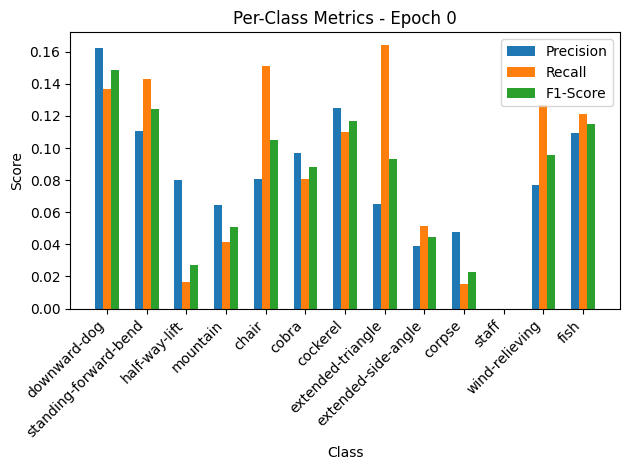

Validation: 100%|██████████| 4/4 [00:13<00:00,  3.35s/it, loss=2.51, accuracy=11.9]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Per-Class Metrics for Epoch 0:
downward-dog: Precision=0.30, Recall=0.38, F1-Score=0.33
standing-forward-bend: Precision=0.00, Recall=0.00, F1-Score=0.00
half-way-lift: Precision=0.00, Recall=0.00, F1-Score=0.00
mountain: Precision=0.33, Recall=0.09, F1-Score=0.14
chair: Precision=0.00, Recall=0.00, F1-Score=0.00
cobra: Precision=0.00, Recall=0.00, F1-Score=0.00
cockerel: Precision=0.00, Recall=0.00, F1-Score=0.00
extended-triangle: Precision=0.00, Recall=0.00, F1-Score=0.00
extended-side-angle: Precision=0.12, Recall=0.14, F1-Score=0.13
corpse: Precision=0.00, Recall=0.00, F1-Score=0.00
staff: Precision=0.00, Recall=0.00, F1-Score=0.00
wind-relieving: Precision=0.00, Recall=0.00, F1-Score=0.00
fish: Precision=0.08, Recall=1.00, F1-Score=0.14


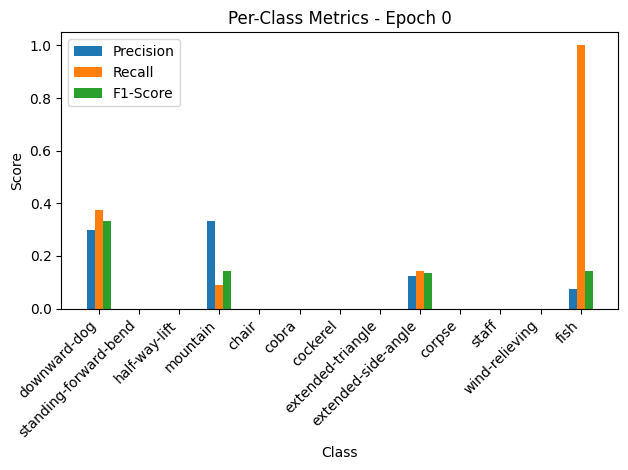


Epoch 1/50 Summary:
Train Loss: 5.3798 | Train Acc: 9.17% | Train Precision: 0.08 | Train Recall: 0.09 | Train F1: 0.08
Val Loss: 2.5497 | Val Acc: 11.90% | Val Precision: 0.06 | Val Recall: 0.12 | Val F1: 0.06
/kaggle/working/BS32_KAGGLE_CROSS_FOLD_2D_CNN_LSTM_2025-02-23_LR0.001_LHS512_LL1_CTresnet18/best_model_fold_3.pth
Saving checkpoint to /kaggle/working/BS32_KAGGLE_CROSS_FOLD_2D_CNN_LSTM_2025-02-23_LR0.001_LHS512_LL1_CTresnet18/best_model_fold_3.pth
Checkpoint saved at epoch 1
New best model saved! Validation Loss: 2.5497

Epoch 2/50
Current Learning Rate: 0.001


Training: 100%|██████████| 36/36 [01:25<00:00,  2.37s/it, loss=3.95, accuracy=14.1]

INPUT_SIZE: 14
TRAIN LOADER LENGTH: 1134
TRAIN TOTAL: 1134
Per-Class Metrics for Epoch 1:
downward-dog: Precision=0.22, Recall=0.19, F1-Score=0.20
standing-forward-bend: Precision=0.19, Recall=0.21, F1-Score=0.20
half-way-lift: Precision=0.19, Recall=0.02, F1-Score=0.04
mountain: Precision=0.16, Recall=0.10, F1-Score=0.13
chair: Precision=0.13, Recall=0.24, F1-Score=0.17
cobra: Precision=0.20, Recall=0.13, F1-Score=0.16
cockerel: Precision=0.05, Recall=0.05, F1-Score=0.05
extended-triangle: Precision=0.13, Recall=0.30, F1-Score=0.18
extended-side-angle: Precision=0.08, Recall=0.10, F1-Score=0.09
corpse: Precision=0.08, Recall=0.05, F1-Score=0.06
staff: Precision=0.06, Recall=0.03, F1-Score=0.04
wind-relieving: Precision=0.15, Recall=0.27, F1-Score=0.19
fish: Precision=0.11, Recall=0.14, F1-Score=0.12


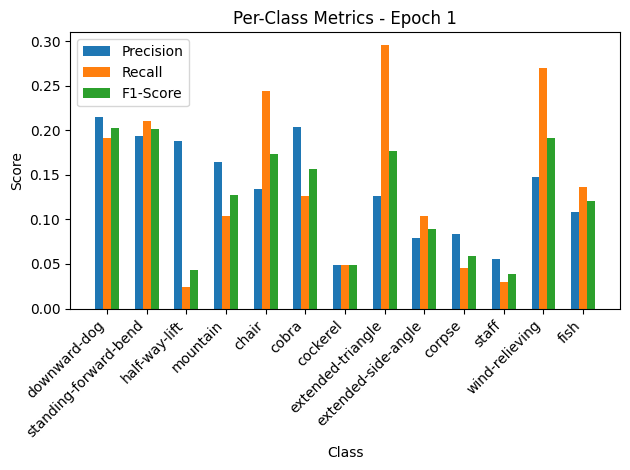

Validation: 100%|██████████| 4/4 [00:04<00:00,  1.19s/it, loss=2.27, accuracy=27]  
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Per-Class Metrics for Epoch 1:
downward-dog: Precision=0.19, Recall=0.88, F1-Score=0.32
standing-forward-bend: Precision=0.00, Recall=0.00, F1-Score=0.00
half-way-lift: Precision=0.00, Recall=0.00, F1-Score=0.00
mountain: Precision=0.88, Recall=0.64, F1-Score=0.74
chair: Precision=0.00, Recall=0.00, F1-Score=0.00
cobra: Precision=0.40, Recall=0.20, F1-Score=0.27
cockerel: Precision=0.20, Recall=0.33, F1-Score=0.25
extended-triangle: Precision=0.00, Recall=0.00, F1-Score=0.00
extended-side-angle: Precision=1.00, Recall=0.14, F1-Score=0.25
corpse: Precision=0.20, Recall=0.43, F1-Score=0.27
staff: Precision=0.00, Recall=0.00, F1-Score=0.00
wind-relieving: Precision=0.50, Recall=0.14, F1-Score=0.22
fish: Precision=0.43, Recall=0.43, F1-Score=0.43


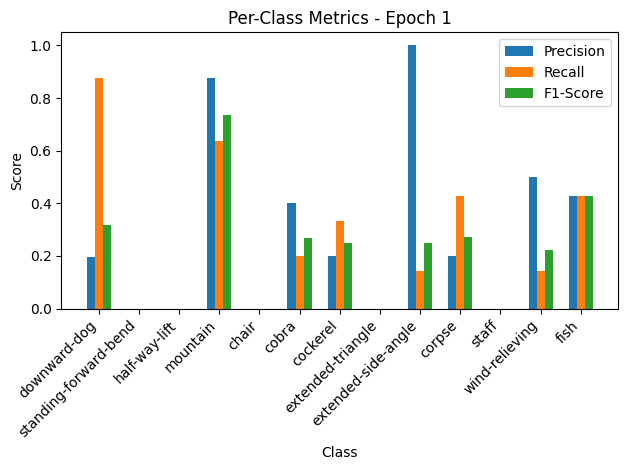


Epoch 2/50 Summary:
Train Loss: 4.0159 | Train Acc: 14.11% | Train Precision: 0.13 | Train Recall: 0.14 | Train F1: 0.13
Val Loss: 2.3029 | Val Acc: 26.98% | Val Precision: 0.29 | Val Recall: 0.25 | Val F1: 0.21
/kaggle/working/BS32_KAGGLE_CROSS_FOLD_2D_CNN_LSTM_2025-02-23_LR0.001_LHS512_LL1_CTresnet18/best_model_fold_3.pth
Saving checkpoint to /kaggle/working/BS32_KAGGLE_CROSS_FOLD_2D_CNN_LSTM_2025-02-23_LR0.001_LHS512_LL1_CTresnet18/best_model_fold_3.pth
Checkpoint saved at epoch 2
New best model saved! Validation Loss: 2.3029

Epoch 3/50
Current Learning Rate: 0.001


Training: 100%|██████████| 36/36 [01:45<00:00,  2.94s/it, loss=3.31, accuracy=19.8]

INPUT_SIZE: 14
TRAIN LOADER LENGTH: 1134
TRAIN TOTAL: 1134
Per-Class Metrics for Epoch 2:
downward-dog: Precision=0.30, Recall=0.28, F1-Score=0.29
standing-forward-bend: Precision=0.23, Recall=0.22, F1-Score=0.22
half-way-lift: Precision=0.41, Recall=0.10, F1-Score=0.16
mountain: Precision=0.16, Recall=0.15, F1-Score=0.15
chair: Precision=0.17, Recall=0.28, F1-Score=0.21
cobra: Precision=0.14, Recall=0.13, F1-Score=0.13
cockerel: Precision=0.10, Recall=0.11, F1-Score=0.10
extended-triangle: Precision=0.16, Recall=0.28, F1-Score=0.20
extended-side-angle: Precision=0.22, Recall=0.19, F1-Score=0.20
corpse: Precision=0.28, Recall=0.14, F1-Score=0.18
staff: Precision=0.24, Recall=0.18, F1-Score=0.21
wind-relieving: Precision=0.21, Recall=0.35, F1-Score=0.26
fish: Precision=0.13, Recall=0.20, F1-Score=0.15


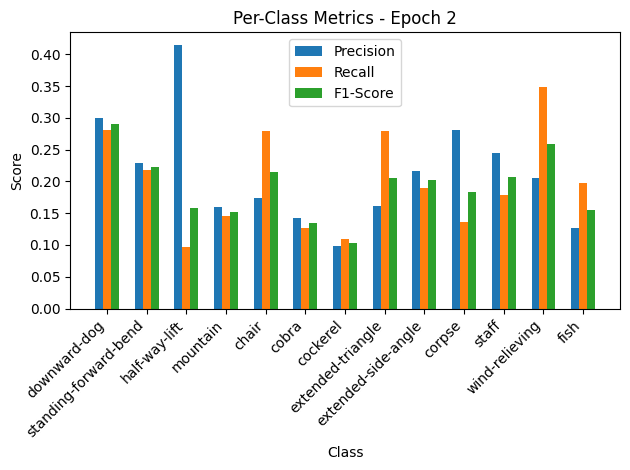

Validation: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it, loss=1.96, accuracy=26.2]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Per-Class Metrics for Epoch 2:
downward-dog: Precision=0.50, Recall=0.06, F1-Score=0.11
standing-forward-bend: Precision=1.00, Recall=0.07, F1-Score=0.12
half-way-lift: Precision=0.00, Recall=0.00, F1-Score=0.00
mountain: Precision=0.41, Recall=0.64, F1-Score=0.50
chair: Precision=0.25, Recall=0.33, F1-Score=0.29
cobra: Precision=0.75, Recall=0.30, F1-Score=0.43
cockerel: Precision=0.00, Recall=0.00, F1-Score=0.00
extended-triangle: Precision=0.19, Recall=1.00, F1-Score=0.33
extended-side-angle: Precision=0.13, Recall=0.57, F1-Score=0.22
corpse: Precision=0.25, Recall=0.43, F1-Score=0.32
staff: Precision=0.00, Recall=0.00, F1-Score=0.00
wind-relieving: Precision=0.33, Recall=0.43, F1-Score=0.38
fish: Precision=0.50, Recall=0.14, F1-Score=0.22


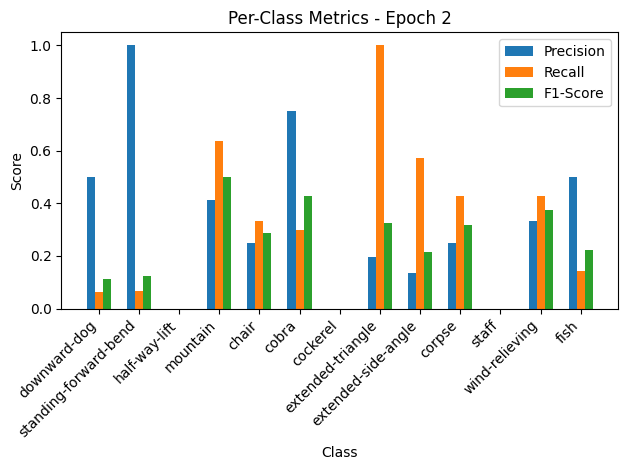


Epoch 3/50 Summary:
Train Loss: 3.3591 | Train Acc: 19.75% | Train Precision: 0.21 | Train Recall: 0.20 | Train F1: 0.19
Val Loss: 1.9959 | Val Acc: 26.19% | Val Precision: 0.33 | Val Recall: 0.31 | Val F1: 0.22
/kaggle/working/BS32_KAGGLE_CROSS_FOLD_2D_CNN_LSTM_2025-02-23_LR0.001_LHS512_LL1_CTresnet18/best_model_fold_3.pth
Saving checkpoint to /kaggle/working/BS32_KAGGLE_CROSS_FOLD_2D_CNN_LSTM_2025-02-23_LR0.001_LHS512_LL1_CTresnet18/best_model_fold_3.pth
Checkpoint saved at epoch 3
New best model saved! Validation Loss: 1.9959

Epoch 4/50
Current Learning Rate: 0.001


Training: 100%|██████████| 36/36 [01:39<00:00,  2.77s/it, loss=2.72, accuracy=23.9]

INPUT_SIZE: 14
TRAIN LOADER LENGTH: 1134
TRAIN TOTAL: 1134
Per-Class Metrics for Epoch 3:
downward-dog: Precision=0.43, Recall=0.39, F1-Score=0.41
standing-forward-bend: Precision=0.22, Recall=0.20, F1-Score=0.21
half-way-lift: Precision=0.19, Recall=0.05, F1-Score=0.08
mountain: Precision=0.22, Recall=0.23, F1-Score=0.22
chair: Precision=0.20, Recall=0.31, F1-Score=0.24
cobra: Precision=0.30, Recall=0.20, F1-Score=0.24
cockerel: Precision=0.16, Recall=0.17, F1-Score=0.16
extended-triangle: Precision=0.20, Recall=0.33, F1-Score=0.25
extended-side-angle: Precision=0.22, Recall=0.19, F1-Score=0.20
corpse: Precision=0.17, Recall=0.12, F1-Score=0.14
staff: Precision=0.29, Recall=0.21, F1-Score=0.24
wind-relieving: Precision=0.28, Recall=0.54, F1-Score=0.37
fish: Precision=0.14, Recall=0.21, F1-Score=0.17


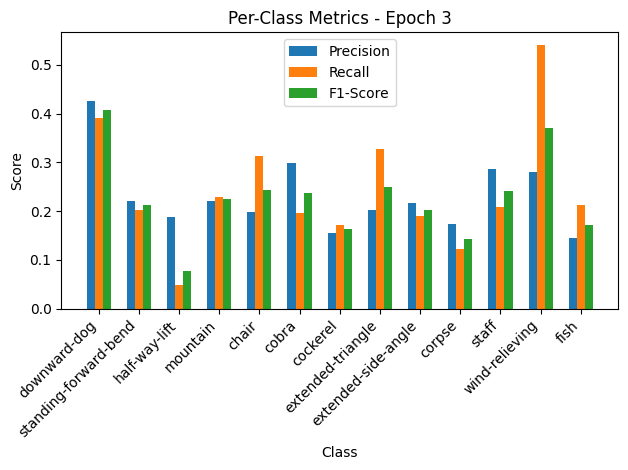

Validation: 100%|██████████| 4/4 [00:05<00:00,  1.28s/it, loss=1.74, accuracy=38.1]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Per-Class Metrics for Epoch 3:
downward-dog: Precision=0.86, Recall=0.38, F1-Score=0.52
standing-forward-bend: Precision=0.62, Recall=0.53, F1-Score=0.57
half-way-lift: Precision=0.00, Recall=0.00, F1-Score=0.00
mountain: Precision=0.62, Recall=0.45, F1-Score=0.53
chair: Precision=0.29, Recall=0.22, F1-Score=0.25
cobra: Precision=0.47, Recall=0.70, F1-Score=0.56
cockerel: Precision=0.33, Recall=0.11, F1-Score=0.17
extended-triangle: Precision=0.60, Recall=0.86, F1-Score=0.71
extended-side-angle: Precision=0.75, Recall=0.43, F1-Score=0.55
corpse: Precision=0.29, Recall=0.29, F1-Score=0.29
staff: Precision=0.20, Recall=0.29, F1-Score=0.24
wind-relieving: Precision=0.50, Recall=0.43, F1-Score=0.46
fish: Precision=0.08, Recall=0.43, F1-Score=0.14


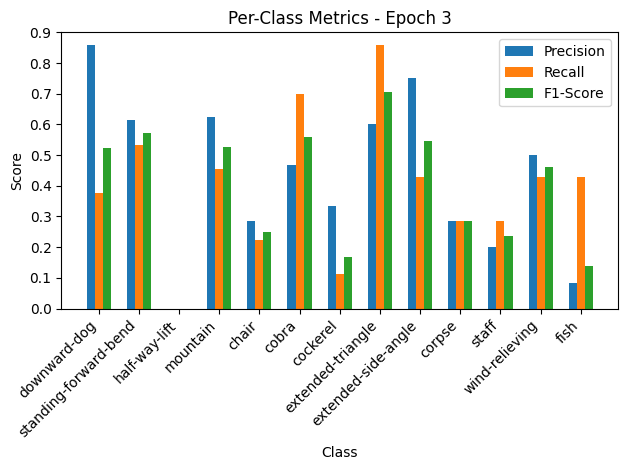


Epoch 4/50 Summary:
Train Loss: 2.7640 | Train Acc: 23.90% | Train Precision: 0.23 | Train Recall: 0.24 | Train F1: 0.23
Val Loss: 1.7719 | Val Acc: 38.10% | Val Precision: 0.43 | Val Recall: 0.39 | Val F1: 0.38
/kaggle/working/BS32_KAGGLE_CROSS_FOLD_2D_CNN_LSTM_2025-02-23_LR0.001_LHS512_LL1_CTresnet18/best_model_fold_3.pth
Saving checkpoint to /kaggle/working/BS32_KAGGLE_CROSS_FOLD_2D_CNN_LSTM_2025-02-23_LR0.001_LHS512_LL1_CTresnet18/best_model_fold_3.pth
Checkpoint saved at epoch 4
New best model saved! Validation Loss: 1.7719

Epoch 5/50
Current Learning Rate: 0.001


Training: 100%|██████████| 36/36 [01:38<00:00,  2.72s/it, loss=2.28, accuracy=31.2]

INPUT_SIZE: 14
TRAIN LOADER LENGTH: 1134
TRAIN TOTAL: 1134
Per-Class Metrics for Epoch 4:
downward-dog: Precision=0.45, Recall=0.38, F1-Score=0.41
standing-forward-bend: Precision=0.39, Recall=0.31, F1-Score=0.34
half-way-lift: Precision=0.31, Recall=0.14, F1-Score=0.19
mountain: Precision=0.35, Recall=0.41, F1-Score=0.37
chair: Precision=0.20, Recall=0.24, F1-Score=0.22
cobra: Precision=0.39, Recall=0.38, F1-Score=0.38
cockerel: Precision=0.18, Recall=0.21, F1-Score=0.19
extended-triangle: Precision=0.24, Recall=0.39, F1-Score=0.30
extended-side-angle: Precision=0.42, Recall=0.41, F1-Score=0.42
corpse: Precision=0.27, Recall=0.29, F1-Score=0.28
staff: Precision=0.32, Recall=0.24, F1-Score=0.27
wind-relieving: Precision=0.35, Recall=0.49, F1-Score=0.41
fish: Precision=0.18, Recall=0.24, F1-Score=0.21


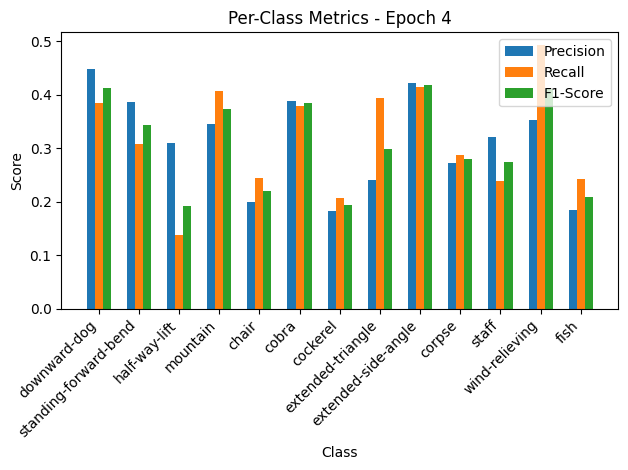

Validation: 100%|██████████| 4/4 [00:04<00:00,  1.10s/it, loss=1.87, accuracy=34.9]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Per-Class Metrics for Epoch 4:
downward-dog: Precision=0.62, Recall=0.81, F1-Score=0.70
standing-forward-bend: Precision=0.80, Recall=0.27, F1-Score=0.40
half-way-lift: Precision=0.42, Recall=0.36, F1-Score=0.38
mountain: Precision=1.00, Recall=0.09, F1-Score=0.17
chair: Precision=0.30, Recall=0.33, F1-Score=0.32
cobra: Precision=1.00, Recall=0.20, F1-Score=0.33
cockerel: Precision=0.14, Recall=0.11, F1-Score=0.12
extended-triangle: Precision=0.25, Recall=0.14, F1-Score=0.18
extended-side-angle: Precision=0.26, Recall=0.71, F1-Score=0.38
corpse: Precision=0.17, Recall=1.00, F1-Score=0.29
staff: Precision=0.00, Recall=0.00, F1-Score=0.00
wind-relieving: Precision=1.00, Recall=0.29, F1-Score=0.44
fish: Precision=0.00, Recall=0.00, F1-Score=0.00


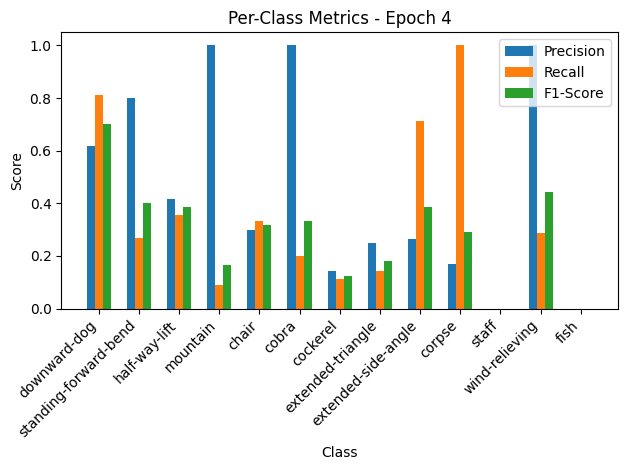


Epoch 5/50 Summary:
Train Loss: 2.3119 | Train Acc: 31.22% | Train Precision: 0.31 | Train Recall: 0.32 | Train F1: 0.31
Val Loss: 1.8976 | Val Acc: 34.92% | Val Precision: 0.46 | Val Recall: 0.33 | Val F1: 0.29

Epoch 6/50
Current Learning Rate: 0.001


Training: 100%|██████████| 36/36 [01:37<00:00,  2.71s/it, loss=2.07, accuracy=34.3]

INPUT_SIZE: 14
TRAIN LOADER LENGTH: 1134
TRAIN TOTAL: 1134
Per-Class Metrics for Epoch 5:
downward-dog: Precision=0.46, Recall=0.42, F1-Score=0.44
standing-forward-bend: Precision=0.33, Recall=0.29, F1-Score=0.31
half-way-lift: Precision=0.42, Recall=0.22, F1-Score=0.29
mountain: Precision=0.40, Recall=0.43, F1-Score=0.41
chair: Precision=0.32, Recall=0.36, F1-Score=0.34
cobra: Precision=0.36, Recall=0.32, F1-Score=0.34
cockerel: Precision=0.30, Recall=0.30, F1-Score=0.30
extended-triangle: Precision=0.26, Recall=0.39, F1-Score=0.31
extended-side-angle: Precision=0.33, Recall=0.41, F1-Score=0.37
corpse: Precision=0.29, Recall=0.21, F1-Score=0.24
staff: Precision=0.42, Recall=0.36, F1-Score=0.39
wind-relieving: Precision=0.34, Recall=0.49, F1-Score=0.40
fish: Precision=0.21, Recall=0.30, F1-Score=0.25


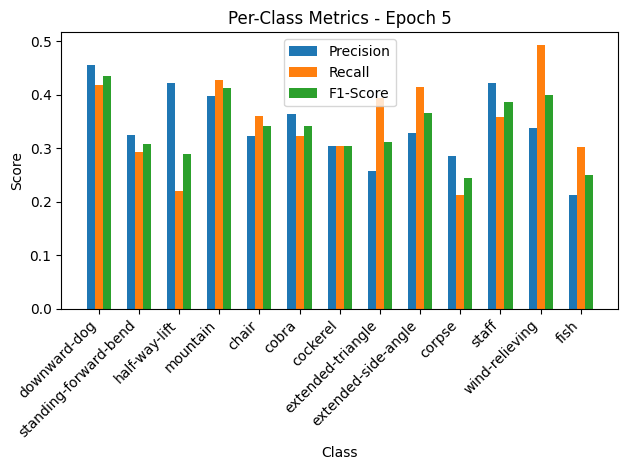

Validation: 100%|██████████| 4/4 [00:04<00:00,  1.11s/it, loss=2.01, accuracy=31.7]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Per-Class Metrics for Epoch 5:
downward-dog: Precision=0.00, Recall=0.00, F1-Score=0.00
standing-forward-bend: Precision=0.40, Recall=0.13, F1-Score=0.20
half-way-lift: Precision=1.00, Recall=0.14, F1-Score=0.25
mountain: Precision=0.44, Recall=0.36, F1-Score=0.40
chair: Precision=0.20, Recall=1.00, F1-Score=0.33
cobra: Precision=0.71, Recall=0.50, F1-Score=0.59
cockerel: Precision=0.00, Recall=0.00, F1-Score=0.00
extended-triangle: Precision=0.00, Recall=0.00, F1-Score=0.00
extended-side-angle: Precision=0.25, Recall=0.86, F1-Score=0.39
corpse: Precision=0.00, Recall=0.00, F1-Score=0.00
staff: Precision=0.24, Recall=0.86, F1-Score=0.38
wind-relieving: Precision=1.00, Recall=0.57, F1-Score=0.73
fish: Precision=0.50, Recall=0.29, F1-Score=0.36


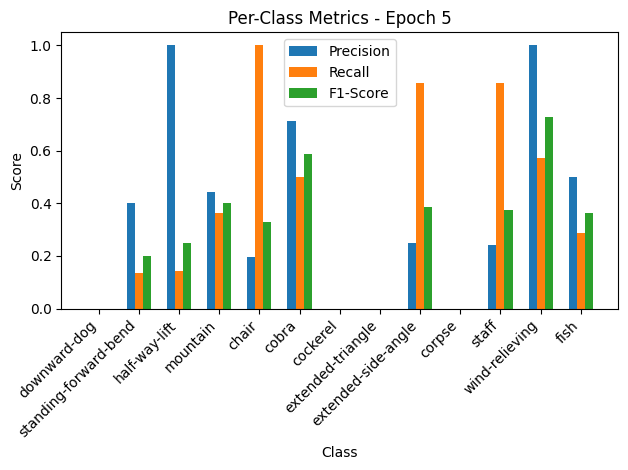


Epoch 6/50 Summary:
Train Loss: 2.0995 | Train Acc: 34.30% | Train Precision: 0.34 | Train Recall: 0.35 | Train F1: 0.34
Val Loss: 2.0437 | Val Acc: 31.75% | Val Precision: 0.36 | Val Recall: 0.36 | Val F1: 0.28

Epoch 7/50
Current Learning Rate: 0.001


Training: 100%|██████████| 36/36 [01:43<00:00,  2.87s/it, loss=1.83, accuracy=39]  

INPUT_SIZE: 14
TRAIN LOADER LENGTH: 1134
TRAIN TOTAL: 1134
Per-Class Metrics for Epoch 6:
downward-dog: Precision=0.58, Recall=0.52, F1-Score=0.55
standing-forward-bend: Precision=0.42, Recall=0.35, F1-Score=0.38
half-way-lift: Precision=0.44, Recall=0.23, F1-Score=0.30
mountain: Precision=0.37, Recall=0.33, F1-Score=0.35
chair: Precision=0.28, Recall=0.38, F1-Score=0.32
cobra: Precision=0.51, Recall=0.44, F1-Score=0.47
cockerel: Precision=0.30, Recall=0.33, F1-Score=0.32
extended-triangle: Precision=0.30, Recall=0.44, F1-Score=0.36
extended-side-angle: Precision=0.36, Recall=0.41, F1-Score=0.38
corpse: Precision=0.41, Recall=0.47, F1-Score=0.44
staff: Precision=0.35, Recall=0.34, F1-Score=0.35
wind-relieving: Precision=0.41, Recall=0.51, F1-Score=0.45
fish: Precision=0.30, Recall=0.38, F1-Score=0.34


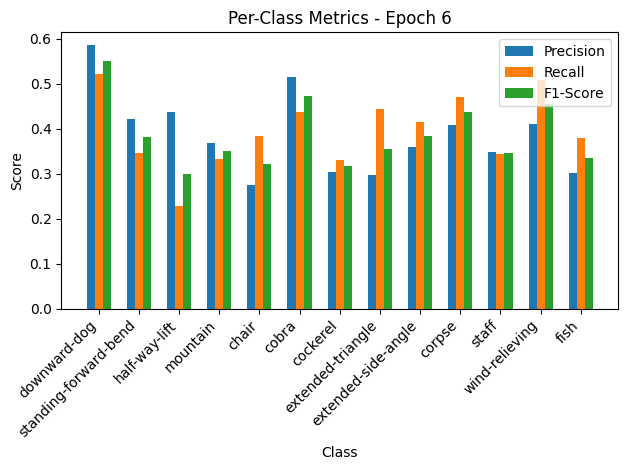

Validation: 100%|██████████| 4/4 [00:05<00:00,  1.43s/it, loss=1.58, accuracy=42.1]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Per-Class Metrics for Epoch 6:
downward-dog: Precision=1.00, Recall=0.06, F1-Score=0.12
standing-forward-bend: Precision=0.75, Recall=0.40, F1-Score=0.52
half-way-lift: Precision=0.50, Recall=0.64, F1-Score=0.56
mountain: Precision=0.67, Recall=0.55, F1-Score=0.60
chair: Precision=0.33, Recall=0.11, F1-Score=0.17
cobra: Precision=0.75, Recall=0.30, F1-Score=0.43
cockerel: Precision=0.33, Recall=0.56, F1-Score=0.42
extended-triangle: Precision=0.23, Recall=0.71, F1-Score=0.34
extended-side-angle: Precision=0.75, Recall=0.43, F1-Score=0.55
corpse: Precision=0.23, Recall=1.00, F1-Score=0.37
staff: Precision=1.00, Recall=0.14, F1-Score=0.25
wind-relieving: Precision=0.60, Recall=0.86, F1-Score=0.71
fish: Precision=0.00, Recall=0.00, F1-Score=0.00


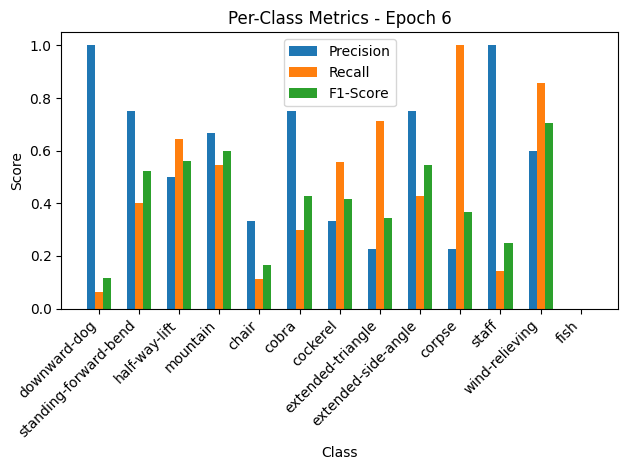


Epoch 7/50 Summary:
Train Loss: 1.8624 | Train Acc: 38.98% | Train Precision: 0.39 | Train Recall: 0.39 | Train F1: 0.38
Val Loss: 1.6031 | Val Acc: 42.06% | Val Precision: 0.55 | Val Recall: 0.44 | Val F1: 0.39
/kaggle/working/BS32_KAGGLE_CROSS_FOLD_2D_CNN_LSTM_2025-02-23_LR0.001_LHS512_LL1_CTresnet18/best_model_fold_3.pth
Saving checkpoint to /kaggle/working/BS32_KAGGLE_CROSS_FOLD_2D_CNN_LSTM_2025-02-23_LR0.001_LHS512_LL1_CTresnet18/best_model_fold_3.pth
Checkpoint saved at epoch 7
New best model saved! Validation Loss: 1.6031

Epoch 8/50
Current Learning Rate: 0.001


Training: 100%|██████████| 36/36 [01:41<00:00,  2.82s/it, loss=1.65, accuracy=45.4]

INPUT_SIZE: 14
TRAIN LOADER LENGTH: 1134
TRAIN TOTAL: 1134
Per-Class Metrics for Epoch 7:
downward-dog: Precision=0.71, Recall=0.58, F1-Score=0.63
standing-forward-bend: Precision=0.52, Recall=0.41, F1-Score=0.46
half-way-lift: Precision=0.56, Recall=0.38, F1-Score=0.45
mountain: Precision=0.40, Recall=0.48, F1-Score=0.44
chair: Precision=0.33, Recall=0.35, F1-Score=0.34
cobra: Precision=0.53, Recall=0.53, F1-Score=0.53
cockerel: Precision=0.33, Recall=0.45, F1-Score=0.38
extended-triangle: Precision=0.43, Recall=0.52, F1-Score=0.47
extended-side-angle: Precision=0.45, Recall=0.43, F1-Score=0.44
corpse: Precision=0.39, Recall=0.36, F1-Score=0.38
staff: Precision=0.40, Recall=0.43, F1-Score=0.42
wind-relieving: Precision=0.46, Recall=0.60, F1-Score=0.52
fish: Precision=0.29, Recall=0.33, F1-Score=0.31


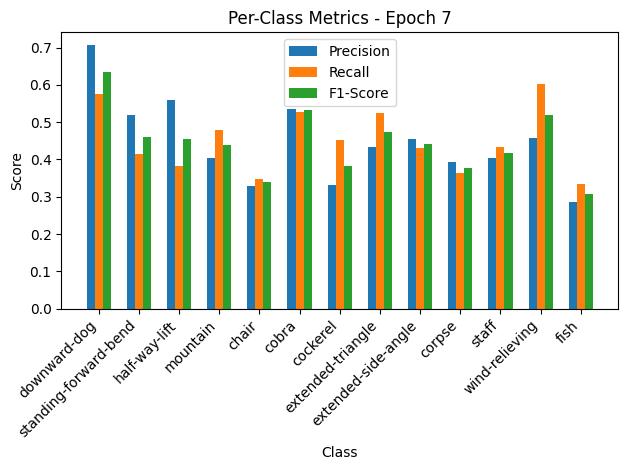

Validation: 100%|██████████| 4/4 [00:04<00:00,  1.15s/it, loss=1.72, accuracy=37.3]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Per-Class Metrics for Epoch 7:
downward-dog: Precision=0.00, Recall=0.00, F1-Score=0.00
standing-forward-bend: Precision=0.40, Recall=0.53, F1-Score=0.46
half-way-lift: Precision=1.00, Recall=0.14, F1-Score=0.25
mountain: Precision=0.83, Recall=0.45, F1-Score=0.59
chair: Precision=0.57, Recall=0.44, F1-Score=0.50
cobra: Precision=0.00, Recall=0.00, F1-Score=0.00
cockerel: Precision=0.21, Recall=0.89, F1-Score=0.34
extended-triangle: Precision=0.50, Recall=0.43, F1-Score=0.46
extended-side-angle: Precision=1.00, Recall=0.14, F1-Score=0.25
corpse: Precision=0.44, Recall=0.57, F1-Score=0.50
staff: Precision=1.00, Recall=0.29, F1-Score=0.44
wind-relieving: Precision=0.27, Recall=0.86, F1-Score=0.41
fish: Precision=0.31, Recall=0.57, F1-Score=0.40


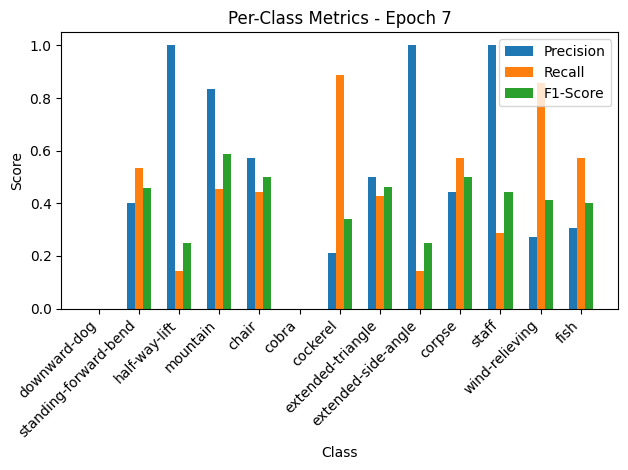


Epoch 8/50 Summary:
Train Loss: 1.6734 | Train Acc: 45.41% | Train Precision: 0.45 | Train Recall: 0.45 | Train F1: 0.44
Val Loss: 1.7490 | Val Acc: 37.30% | Val Precision: 0.50 | Val Recall: 0.41 | Val F1: 0.35

Epoch 9/50
Current Learning Rate: 0.001


Training: 100%|██████████| 36/36 [01:39<00:00,  2.76s/it, loss=1.57, accuracy=46.4]

INPUT_SIZE: 14
TRAIN LOADER LENGTH: 1134
TRAIN TOTAL: 1134
Per-Class Metrics for Epoch 8:
downward-dog: Precision=0.62, Recall=0.56, F1-Score=0.59
standing-forward-bend: Precision=0.47, Recall=0.38, F1-Score=0.42
half-way-lift: Precision=0.47, Recall=0.28, F1-Score=0.36
mountain: Precision=0.50, Recall=0.60, F1-Score=0.55
chair: Precision=0.45, Recall=0.38, F1-Score=0.42
cobra: Precision=0.64, Recall=0.62, F1-Score=0.63
cockerel: Precision=0.37, Recall=0.38, F1-Score=0.37
extended-triangle: Precision=0.33, Recall=0.41, F1-Score=0.36
extended-side-angle: Precision=0.37, Recall=0.59, F1-Score=0.45
corpse: Precision=0.40, Recall=0.38, F1-Score=0.39
staff: Precision=0.43, Recall=0.43, F1-Score=0.43
wind-relieving: Precision=0.47, Recall=0.63, F1-Score=0.54
fish: Precision=0.38, Recall=0.44, F1-Score=0.41


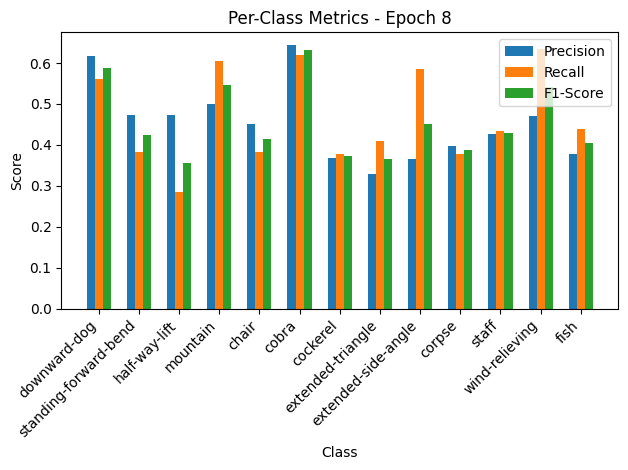

Validation: 100%|██████████| 4/4 [00:04<00:00,  1.14s/it, loss=1.65, accuracy=36.5]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Per-Class Metrics for Epoch 8:
downward-dog: Precision=0.00, Recall=0.00, F1-Score=0.00
standing-forward-bend: Precision=0.40, Recall=0.67, F1-Score=0.50
half-way-lift: Precision=0.00, Recall=0.00, F1-Score=0.00
mountain: Precision=0.30, Recall=0.55, F1-Score=0.39
chair: Precision=0.36, Recall=0.44, F1-Score=0.40
cobra: Precision=1.00, Recall=0.20, F1-Score=0.33
cockerel: Precision=0.67, Recall=0.22, F1-Score=0.33
extended-triangle: Precision=0.33, Recall=0.14, F1-Score=0.20
extended-side-angle: Precision=0.35, Recall=1.00, F1-Score=0.52
corpse: Precision=0.38, Recall=0.86, F1-Score=0.52
staff: Precision=0.33, Recall=0.14, F1-Score=0.20
wind-relieving: Precision=0.32, Recall=1.00, F1-Score=0.48
fish: Precision=0.00, Recall=0.00, F1-Score=0.00


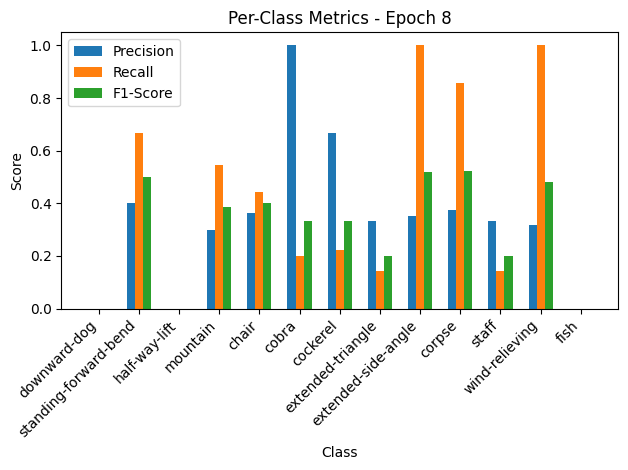


Epoch 9/50 Summary:
Train Loss: 1.5931 | Train Acc: 46.38% | Train Precision: 0.45 | Train Recall: 0.47 | Train F1: 0.45
Val Loss: 1.6723 | Val Acc: 36.51% | Val Precision: 0.34 | Val Recall: 0.40 | Val F1: 0.30

Epoch 10/50
Current Learning Rate: 0.001


Training: 100%|██████████| 36/36 [01:40<00:00,  2.80s/it, loss=1.51, accuracy=47.7]

INPUT_SIZE: 14
TRAIN LOADER LENGTH: 1134
TRAIN TOTAL: 1134
Per-Class Metrics for Epoch 9:
downward-dog: Precision=0.69, Recall=0.55, F1-Score=0.62
standing-forward-bend: Precision=0.45, Recall=0.44, F1-Score=0.44
half-way-lift: Precision=0.49, Recall=0.23, F1-Score=0.31
mountain: Precision=0.48, Recall=0.52, F1-Score=0.50
chair: Precision=0.38, Recall=0.35, F1-Score=0.37
cobra: Precision=0.55, Recall=0.54, F1-Score=0.54
cockerel: Precision=0.34, Recall=0.40, F1-Score=0.37
extended-triangle: Precision=0.36, Recall=0.57, F1-Score=0.44
extended-side-angle: Precision=0.52, Recall=0.55, F1-Score=0.53
corpse: Precision=0.46, Recall=0.53, F1-Score=0.49
staff: Precision=0.47, Recall=0.51, F1-Score=0.49
wind-relieving: Precision=0.53, Recall=0.70, F1-Score=0.60
fish: Precision=0.44, Recall=0.52, F1-Score=0.47


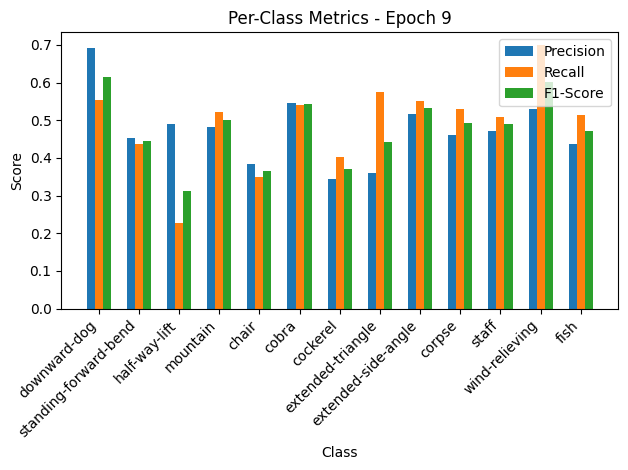

Validation: 100%|██████████| 4/4 [00:04<00:00,  1.08s/it, loss=1.72, accuracy=46]  


Per-Class Metrics for Epoch 9:
downward-dog: Precision=1.00, Recall=0.69, F1-Score=0.81
standing-forward-bend: Precision=0.48, Recall=0.73, F1-Score=0.58
half-way-lift: Precision=1.00, Recall=0.21, F1-Score=0.35
mountain: Precision=0.00, Recall=0.00, F1-Score=0.00
chair: Precision=0.19, Recall=0.33, F1-Score=0.24
cobra: Precision=1.00, Recall=0.20, F1-Score=0.33
cockerel: Precision=0.30, Recall=0.78, F1-Score=0.44
extended-triangle: Precision=0.50, Recall=0.14, F1-Score=0.22
extended-side-angle: Precision=0.55, Recall=0.86, F1-Score=0.67
corpse: Precision=1.00, Recall=0.14, F1-Score=0.25
staff: Precision=0.28, Recall=0.71, F1-Score=0.40
wind-relieving: Precision=0.46, Recall=0.86, F1-Score=0.60
fish: Precision=1.00, Recall=0.29, F1-Score=0.44


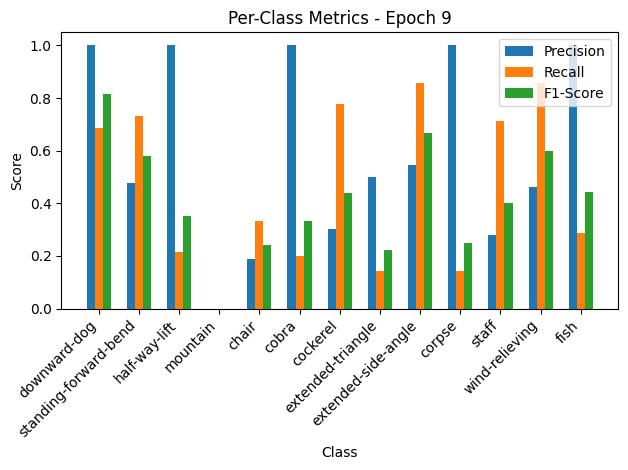


Epoch 10/50 Summary:
Train Loss: 1.5344 | Train Acc: 47.71% | Train Precision: 0.47 | Train Recall: 0.49 | Train F1: 0.48
Val Loss: 1.7429 | Val Acc: 46.03% | Val Precision: 0.60 | Val Recall: 0.46 | Val F1: 0.41

Epoch 11/50
Current Learning Rate: 0.001


Training: 100%|██████████| 36/36 [01:43<00:00,  2.88s/it, loss=1.48, accuracy=51]  

INPUT_SIZE: 14
TRAIN LOADER LENGTH: 1134
TRAIN TOTAL: 1134
Per-Class Metrics for Epoch 10:
downward-dog: Precision=0.61, Recall=0.60, F1-Score=0.60
standing-forward-bend: Precision=0.46, Recall=0.33, F1-Score=0.39
half-way-lift: Precision=0.58, Recall=0.37, F1-Score=0.45
mountain: Precision=0.52, Recall=0.59, F1-Score=0.55
chair: Precision=0.46, Recall=0.43, F1-Score=0.45
cobra: Precision=0.66, Recall=0.71, F1-Score=0.69
cockerel: Precision=0.37, Recall=0.40, F1-Score=0.38
extended-triangle: Precision=0.43, Recall=0.62, F1-Score=0.51
extended-side-angle: Precision=0.49, Recall=0.60, F1-Score=0.54
corpse: Precision=0.41, Recall=0.45, F1-Score=0.43
staff: Precision=0.51, Recall=0.58, F1-Score=0.54
wind-relieving: Precision=0.56, Recall=0.68, F1-Score=0.61
fish: Precision=0.47, Recall=0.42, F1-Score=0.45


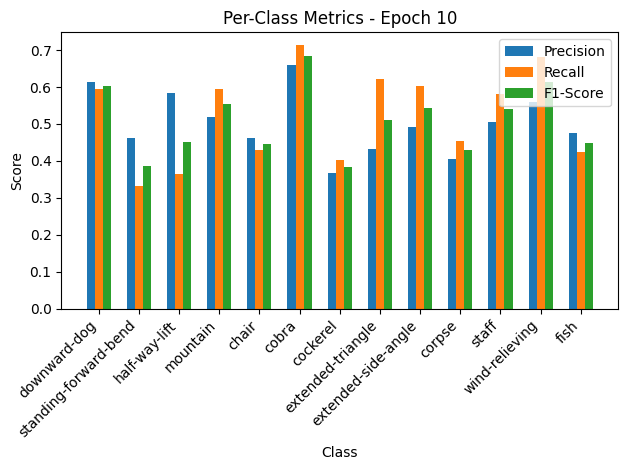

Validation: 100%|██████████| 4/4 [00:04<00:00,  1.09s/it, loss=1.66, accuracy=37.3]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Per-Class Metrics for Epoch 10:
downward-dog: Precision=1.00, Recall=0.19, F1-Score=0.32
standing-forward-bend: Precision=0.38, Recall=0.20, F1-Score=0.26
half-way-lift: Precision=0.75, Recall=0.43, F1-Score=0.55
mountain: Precision=0.00, Recall=0.00, F1-Score=0.00
chair: Precision=0.80, Recall=0.44, F1-Score=0.57
cobra: Precision=0.31, Recall=0.50, F1-Score=0.38
cockerel: Precision=0.13, Recall=0.22, F1-Score=0.17
extended-triangle: Precision=0.56, Recall=0.71, F1-Score=0.63
extended-side-angle: Precision=0.57, Recall=0.57, F1-Score=0.57
corpse: Precision=0.20, Recall=0.43, F1-Score=0.27
staff: Precision=0.50, Recall=0.14, F1-Score=0.22
wind-relieving: Precision=0.29, Recall=1.00, F1-Score=0.45
fish: Precision=0.29, Recall=0.57, F1-Score=0.38


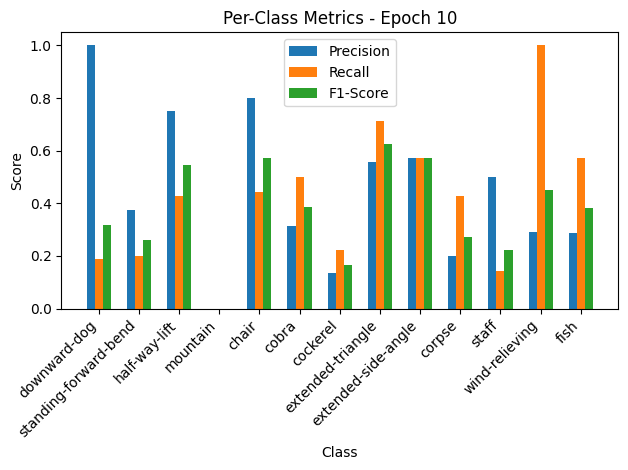


Epoch 11/50 Summary:
Train Loss: 1.5029 | Train Acc: 50.97% | Train Precision: 0.50 | Train Recall: 0.52 | Train F1: 0.51
Val Loss: 1.6846 | Val Acc: 37.30% | Val Precision: 0.44 | Val Recall: 0.42 | Val F1: 0.37

Epoch 12/50
Current Learning Rate: 0.001


Training:  53%|█████▎    | 19/36 [00:51<00:48,  2.87s/it, loss=1.43, accuracy=50.2]

In [ ]:
if __name__ == "__main__":
    main()

In [ ]:
!zip -r /kaggle/working/RENET_18_FROZEN_FEB_26.zip /kaggle/working


In [ ]:
!ls /kaggle/working

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch
import numpy as np
import os
from tqdm import tqdm
import csv

def find_sus(model, test_loader, criterion, class_names, spath=SAVE_PATH, fsave='confusion_matrix_all.png'):
    """
    Evaluate model on test set

    Args:
        model: PyTorch model
        test_loader: DataLoader for test data
        criterion: Loss function
        class_names: List of class names
        save_path: Directory to save the plot
        fsave: Filename for confusion matrix plot
    """
    csave = os.path.join(spath, fsave)
    sussave = os.path.join(spath, 'sus.csv')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    test_loss = 0.0
    test_correct = 0
    test_total = 0
    all_predictions = []
    all_labels = []
    misclassified_data = []

    # Create progress bar
    test_loader_tqdm = tqdm(test_loader, desc="Testing")

    with torch.no_grad():
        for batch_idx, (inputs, labels, lengths) in enumerate(test_loader_tqdm):
            inputs = inputs.to(device)
            labels = labels.to(device)
            lengths = lengths.to(device)
            # Forward pass
            outputs = model(inputs, lengths)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            # Get predictions
            _, predicted = torch.max(outputs, 1)
            # Calculate accuracy
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)

            # Store predictions and labels for confusion matrix
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Check if the sample is misclassified
            misclassified_indices = (predicted != labels).nonzero(as_tuple=True)[0]
            for misclassified_idx in misclassified_indices:
                global_idx = batch_idx * inputs.size(0) + misclassified_idx.item()
                sequence_id = test_loader.dataset.idx_to_label[global_idx]
                correct_label = class_names[labels[misclassified_idx].item()]
                prediction = class_names[predicted[misclassified_idx].item()]
                misclassified_data.append([sequence_id, correct_label, prediction])

    # Calculate metrics
    test_loss = test_loss / len(test_loader.dataset)
    accuracy = 100 * test_correct / test_total

    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=pose_list, yticklabels=pose_list)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Save the plot
    plt.savefig(csave)
    plt.show()
    plt.close()

    # Save misclassified data to CSV
    with open(sussave, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['sequence_id', 'correct_label', 'prediction'])
        writer.writerows(misclassified_data)

    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {accuracy:.2f}%')

    return test_loss, accuracy

In [ ]:
dataset, train_dataset, test_dataset = prepare_dataset()
label_to_pose = {v:k for k,v in dataset.pose_to_label.items()}

model = CNNLSTM(num_classes=NUM_CLASSES, lstm_hidden_size=LSTM_HIDDEN_SIZE, lstm_layers=LSTM_LAYERS, dropout=DROPOUT, cnn_model = CNN_TYPE)
# criterion = nn.CrossEntropyLoss()
all_labels = [dataset[i][1] for i in range(len(dataset))]
criterion = create_weighted_criterion(
        all_labels,
        num_classes= NUM_CLASSES,
        strategy='inverse'  # Try different strategies
    )
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

checkpoint_path = os.path.join(SAVE_PATH, 'best_model.pth')
# Plot the training curves
if checkpoint_path and os.path.exists(checkpoint_path):
        model, optimizer, start_epoch, history = load_checkpoint(
            model, optimizer, checkpoint_path
        )
        print(f"Resuming training from epoch {start_epoch}")
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
# plot_training_curves(history)
find_sus(model, loader, criterion, label_to_pose)